# w261 Final Project - Clickthrough Rate Prediction


### Team 24   
### Vivian Lu, Siddhartha Jakkamreddy, Venky Nagapudi, Luca Garre   
### Summer 2019, sections 4 and 5   

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# __Section 1__ - Question Formulation

## __Introduction__
Online ad is a multibillion dollar industry fueled by large investments and ever increasing performance goals. Targeted advertisement, based on users' demographics and browsing history as well as tailored ad features (i.e. colors, text, placement on webpage, display size), is receiving more and more interest due to its potential for revenue generation. As such, machine learning is proving resourceful in the understanding of which features have the greatest impact on users' Click-Through Rates (CTR) and thus informing ad design to maximize performance metrics such as click and convertion rates. Such machine learning solutions can also be deployed in a data pipeline environment (i.e. streaming) to select and offer the best ad on a user/event specific basis that will maximize profit. 

## __Goal of the analysis__
The purpose of the present analysis is to estimate whether a given ad will be clicked based on a set of features (both numerical and categorical) describing the ad. Our analysis attempts to first delve into understanding the anonymized features on an exploratory data analysis, and following such an investigation, we attempt to construct a machine learning model that predict a binary outcome variable (1 for successful click through, 0 for unsuccessful click through) based on features that have shown significant association with the labelled outcome variable of click through rate (CTR). 

## __Description of the dataset__
The dataset is provided by Criteo on Kaggle(https://www.kaggle.com/c/criteo-display-ad-challenge) and is composed of three files, a `readme.txt`, a `train.txt` and a `test.txt` file, respectively. The readme file contains a brief description of the data. The `train.txt` and `test.txt` files contain the train and test data. Both files are formatted as tab separated value tables, and amount to 45840617 and 6042135 rows for the train and test data, respectively. Following the description of the data, each row represents an ad and contains the following fields (see commands below, these expect the data to be contained in a data folder inside the current working directory):

- 1 binary field indicating whether the ad has been clicked (1) or not (0). This field is available only for the train data;
- 13 fields containing integer features representing counts;
- 26 categorical features. These are hashed as 32 bits keys for anonymization purposes;

From a printout of the first rows of the data files it appears that the data contain no headers. This implies that, with the sole exception of the first binary field, it is not possible to characterize the various fields in terms of the features these represent. It is also noted that rows in the data can have missing values. This is again noticed when looking at the printed lines, as these have a number of entries which is lower than the number of fields specified in the `readme.txt` file. 

In [41]:
#number of rows in the train data
!wc -l data/train.txt

wc: data/train.txt: No such file or directory


In [ ]:
#number of rows in the test data
!wc -l data/test.txt

In [ ]:
# first row of the train data
!head -1 data/train.txt

In [ ]:
# first row of the test data
!head -1 data/test.txt

# __Section 2__ - Algorithm Explanation

## Summary and Organization of work

The algorithmic approach that we adopted towards solving the CTR prediction problem was based on the fact that a simple linear Logistic Regression alone would not be sufficient. CTR prediction depends on the interactions between features in addition to the features themselves. For example, there are likely features such as `advertiser_id` and `consumer_id` in the categorical variables. Whether an ad is clicked on or not likely depends on the interaction between these two variables and not just on each of them alone. 

As such we need to include the products of features in addition to the features, thereby requiring a higher order quadratic Logistic Regression rather than linear.

The logistic regression will need to include interaction terms, and therefore 2nd Degree polynomial features. The below equation represents the formulation.

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} +  \sum_{i=1}^n \sum_{j=i+1}^n w_{ij} x_{i} x_{j}
\end{align}

The second term can grows at `O(n^2)` which makes this a difficult problem to solve. As it is, since a number of categorical variables are involved such as `advertiser_id` and `consumer_id`, the dimensionality of the linear variables can run into millions. While we show how we can reduce this to hundreds of terms with several techniques, we could run into really large dimensions for the interaction terms (ex: 1 million interaction terms for 1000 features) which make practical implementations computationally challenging.

We address this problem through dimensionality reduction of the quadratic terms using Factorization Machine (FM) methods. Using Latent Factors (in our case 2), we reduce the complexity of the problem to a manageable `O(n)` rather than `O(n^2)`

In Section 2.1, we discuss the Logistic Regression algorithm and describe how we use Gradient Descent to solve this problem.

In Section 2.2, we present the Factorization Machine (FM) that we used to address the interaction terms. We show how to derive a Gradient Descent method that extends the Logistic Regression framework to address the interaction terms


### 2.1 Logistic regression

Logistic regression belongs to the family of so-called generalized linear models and is by far one of the most known and applied algorithms for the prediction of a target variable $Y$, which represents the possible occurrence of an event of interest $e$. This variable is binary, and usually is encoded such that $Y=1$ represents the occurrence of $e$. More specifically, given a set of explanatory features $X_i$, $i = 1,2, \dots, n$, logistic regression characterizes the probability of occurrence of $e$, $\pi[e] \equiv \pi$, as follows:

\begin{equation}
\pi = \frac{1}{1 + \exp^{-z} }
\end{equation}

where $z = \beta_0 + \sum_{i=1}^n \beta_i X_i$ and $\beta_i$ are model parameters. As can be seen from the equation above, and in compliance with probability rules, $\pi \in (0, 1)$ for any $\beta_i$ and $X_i$, owing to the fact that the exponential function is strictly positive, and considering that the denominator is always higher than the numerator. After some algebraic manipulations an equivalent, and more compact, formulation of the above equation can be obtained as:

\begin{equation}
log\left( \frac{\pi}{1-\pi} \right) = \beta_0 + \sum_{i=1}^n \beta_i X_i
\end{equation}

where the left side is usually referred to as the logit function, $logit(\pi)$, while the right side makes the linear nature of this model explicit. This becomes clearer when considering the decision boundary, i.e., the hypersurface that segments the feature space in positive versus vegative regions. For logistic regression, such boundary is associated with the locus of points in the feature space where $\pi=0.5$, i.e., the model has no preference as to whether a point in this locus should be assigned to the positive or the negative class. Casting $\pi=0.5$ in the left side of the equation above renders a linear equation of the decision boundary in the feature space, in compliance with the linear nature of this model.  

### Log-loss function and parameter estimation

In accordance with established practices in the fields of statistics and machine learning, the parameters $\beta_i$ of the logistic regression model are estimated via maximization of the log-likelihood function. In essence, for a sample of $m$ data points $(x_{ij}, y_j)$, $i = 1,2,\dots,n$, $j = 1,2,\dots,m$, where $x_{ij}$ is the $j$-th record of the $i$-th feature, and $y_j$ is the $j$-th record of the target binary variable $Y$, the parameters $\beta_i$ are estimated such that the log-likelihood function:

\begin{equation}
log\left[ L(\beta_i|y_j) \right] = \frac{1}{m} log\left( \prod_{j = 1}^{m} \pi_j^{y_j} \left( 1-\pi_j \right)^{1-y_j} \right)
\end{equation}

is maximized. The term in the multiplication corresponds to the likelihood function of the Bernoulli distribution for the (degenerate) case of one single trial and number of successes $y_j = 1$ and $y_j = 0$ for success and failure, respectively.

Operationally, the above maximization is usually achieved taking the negative of the log-likelihood function and computing the parameters $\beta_i$ as the argmin of the negated log-likelihood which, after some manipulations, can be written as:

\begin{equation}
\hat{L} = -log\left[ L(\beta_i|y_j) \right] = - \frac{1}{m}\sum_{j=1}^{m} \left[ y_j \cdot log(\pi_j) + (1-y_j) \cdot log(1-\pi_j) \right]
\end{equation}

The right term of the equation, also called Cross-Entropy or log-loss, being a function $\pi$, is ultimately a function of the parameters $\beta_i$ and the features $X_i$ through the logistic regression relationship. The log-loss gives some insights as to the role of this function during estimation of the parameters. Let us assume that for a certain data point, $(x_{ij}, y_j)$, the target variable is equal to $1$. For this given data point, the right term of the equation simplifies to $-log(\pi_j)$. Since this term needs to be minimized, the parameters $\beta_i$ of the model need to be chosen such that $\pi_j$ approaches $1$ as closely as possible. Conversely for an observation $y_j = 0$, minimization of the log-loss, $-log(1 - \pi_j)$, requires $\pi_j$ to approach $0$. This dual role of the log-loss function makes such that likelihood maximization in logistic regression aims to find the set of model parameters which best separate positive from negative observations in the space of the explanatory features $X_i$, in the sense of mapping as closely as possible positive targets to $\pi = 1$ and negative targets to $\pi = 0$. Another appealing property, which turns out to the be of paramount importance for the strategy outlined below, is that this log-loss function is convex, i.e., one and only one point of minimum exists in the space of parameters $\beta_i$.

### Gradient descent

Finding the optimum set of parameters requires a suitable optimization framework. Among various approaches, gradient descent of $\hat{L}$ is a well-established approach for functions. For a certain point of the $n$-th dimensional space of parameters $\beta_i$, the gradient of the log-loss function, $\nabla \hat{L}$ is computed, and thereafter a translation is performed in the parameter space along the gradient direction (the steepest descent).

Gradient descent requires the computation of the gradient. In order to derive its formulation, it is convenient to consider the $i$-th component of $\nabla \hat{L}$, i.e.:

\begin{equation}
\nabla_i \hat{L} = \frac{\partial}{\partial \beta_i} \hat{L}
\end{equation}

Taking the derivative inside the summation and operating on the logarithm yields:

\begin{equation}
\nabla_i \hat{L} = - \frac{1}{m} \sum_{j=1}^{m} \left( \frac{y_j}{\pi_j} - \frac{1-y_j}{1-\pi_j} \right) \frac{\partial \pi_j}{\partial \beta_i}
\end{equation}

The derivative of the probability with respect to the parameter equates to (refer to the initial logistic regression formulation):

\begin{equation}
\frac{\partial \pi_j}{\partial \beta_i} = \frac{\exp^{-z_j}}{(1+\exp^{-z_j})^2} \frac{\partial z_j} {\partial \beta_i} = \frac{\exp^{-z_j}}{1+\exp^{-z_j}} \frac{1}{1+\exp^{-z_j}} \frac{\partial z_j} {\partial \beta_i} = (1-\pi_j) \pi_j \frac{\partial z_j} {\partial \beta_i}
\end{equation}

The derivative of the linear combination term yields:

\begin{equation}
\frac{\partial z_j} {\partial \beta_i} = x_{ij}
\end{equation}

Putting it all together, one finally obtains: 

\begin{equation}
\nabla_i \hat{L} = - \frac{1}{m} \sum_{j=1}^{m} \left[ y_j (1-\pi_j) - (1-y_j) \pi_j \right] x_{ij} = \frac{1}{m}\sum_{j=1}^{m} (\pi_j-y_j) x_{ij}
\end{equation}

for $i = 1,2,\dots,n$. 

Assuming a certain starting point in the space of parameters, $\beta_i^0$, gradient descent first computes the gradient $\nabla \hat{L}$ at this starting point, and shifts the point along the direction of this gradient by computing a new point $\beta_i^1 = \beta_i^0 - \alpha \cdot \nabla \hat{L}$, where $\alpha$ is a learning rate. This is done iteratively until suitable stopping criteria are met.

### Regularization

In certain context it may be valuable to introduce so-called regulaziation terms. These are additional penalties imposed on the loss function which are directly proportional to the magnitude of the model parameters $\beta_i$. Two main regularization approaches exist:

- Ridge regularization:

  in ridge regularization the regularization term amounts to $\lambda \cdot ||\beta||$, where $\lambda$ is a regularization parameter and $\lambda \cdot ||\beta||$ is the norm of the vector of model parameters. As a result of the introduction of the ridge regularization term, the following ridge-regularized gradient descent formula is obtained:

\begin{equation}
\nabla_i \hat{L}_{reg} = \nabla_i \hat{L} + 2 \lambda \beta_i
\end{equation}

- Lasso regularization:

  in lasso regularization the regularization term amounts to $\lambda \cdot \sum_{i=1}^n |\beta_i|$, where $\lambda$ is a regularization parameter and $|\beta_i|$ is the absolute value of the $i$th model parameter. As a result of the introduction of the ridge regularization term, the following ridge-regularized gradient descent formula is obtained, where $sign(x)$ is the sign function:

\begin{equation}
\nabla_i \hat{L}_{reg} = \nabla_i \hat{L} + \lambda sign(\beta_i)
\end{equation}

To note that in both regularization approaches the intercept $\beta_0$ is omitted from the computation of the regularization term, and the intercept itself is not regularized.

### Algorithm for scalable implementation of logistic regression

- Assume starting values for logistic parameters $\beta_i^0$
- Set learning parameter $\alpha$ and regularization parameter $\lambda$
- For each iteration $k$:
- Broadcast parameters $\beta_i^{k}$ to all worker nodes
- Map: emit key-value pairs. Key: index $j$, values: target variable $y_j$ and array of explanatory features $x_{ij}$, for $j = 1,2,\dots,n$
- Map: for every $j = 1,2,\dots,n$ compute probability $\pi_j$ and $\left[ y_j (1-\pi_j) - (1-y_j) \pi_j \right] x_{ij}$
- Reduce: sum over $j$ and divide by $m$, for $i = 1,2,\dots,n$
- Update $\beta_i^{k}$
- Run next iteration

__References:__

Bilder, C.R. and Loughin, T.M. (2015). Analysis of Categorical Data with R. CRC Press. 

Kremonic, Z. (2017). Maximum likelihood and gradient descent demonstration. Blog post. Accessed on July 2019 at https://zlatankr.github.io/posts/2017/03/06/mle-gradient-descent.



Additional resources:

https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

https://ttic.uchicago.edu/~suriya/website-intromlss2018/course_material/Day3b.pdf 

http://www.holehouse.org/mlclass/06_Logistic_Regression.html


## 2.2 Factorization Machine (FM)

The logistic regression will take care of the linear terms, now to account for the interaction term, we expand to include 2nd Degree polynomial features. The below equation represents the formulation.

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} +  \sum_{i=1}^n \sum_{j=i+1}^n w_{ij} x_{i} x_{j}
\end{align}

The challenge with solving the above equation is that the time complexity is $O(n^2)$

In order to work with this, we use a matrix factorization technique for the interaction terms, inspired by Matrix factorization. We introduce a hyperpameter K which represent the latent factors for factorizing the weight vector $w_{ij}$.

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} + \sum_{i=1}^{n} \sum_{j=i+1}^n \langle \textbf{v}_i , \textbf{v}_{j} \rangle x_i x_{j}
\end{align}


Using the computation specified in Stephen Rendles paper, we can simplify the interaction term to the below equation.

\begin{align}
\sum_{i=1}^n \sum_{j=i+1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j}
&= \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j} - \frac{1}{2} \sum_{i=1}^n \langle \textbf{v}_i , \textbf{v}_{i} \rangle x_{i} x_{i}  \\
&= \frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n \sum_{f=1}^k v_{i,f} v_{j,f} x_{i} x_{j} \right)\frac{1}{2}\left( \sum_{i=1}^n \sum_{f=1}^k v_{i,f} v_{i,f} x_{i} x_{i} \right) \\
&= \frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n \sum_{f=1}^k v_{i,f} v_{j,f} x_{i} x_{j}  -  \sum_{i=1}^n \sum_{f=1}^k v_{i,f} v_{i,f} x_{i} x_{i} \right) \\
&= \frac{1}{2} \sum_{f=1}^{k} \left( \left(\sum_{i=1}^n v_{i,f}x_{i} \right) \left( \sum_{j=1}^n v_{j,f}x_{j} \right) - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right) \\
&= \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_{i} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)
\end{align}

So, we can rewrite the equation to compute in $O(n)$ as
\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} + \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_{i} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)
\end{align}

#### Gradient

For our classification problem, we can define the gradients as :

\begin{align}
\frac{\partial}{\partial\theta}\hat{y}(\textbf{x}) =
\begin{cases}
1,  & \text{if $\theta$ is $w_0$} \\
x_i, & \text{if $\theta$ is $w_i$} \\
x_i\sum_{j=1}^{n} v_{j,f}x_j - v_{i,f}x_{i}^2 & \text{if $\theta$ is $v_{i,f}$}
\end{cases}
\end{align}

#### For labels -1&1
\begin{align}
\frac{\partial}{\partial \hat{y} }(\textbf{L}) =
\frac{d}{d \hat{y}}\left[ -y \hat{y} + \ln \big(e^{y \hat{y}} + 1 \big) \right] 
&= \frac{1}{e^{y \hat{y}} + 1} \cdot  \frac{d}{dx}\left[e^{y \hat{y}} + 1 \right] - y \\
&= \frac{ye^{y \hat{y}}}{e^{y \hat{y}} + 1} - y\\
&= \frac{-y}{e^{y \hat{y}} + 1}
\end{align}

#### For labels 0,1
\begin{align}
\frac{\partial}{\partial \hat{y} }(\textbf{L}) =
\frac{d}{d \hat{y}}\left[ -y \hat{y} + \ln \big(e^{ \hat{y}} + 1 \big) \right] 
&= \frac{1}{e^{\hat{y}} + 1} \cdot  \frac{d}{dx}\left[e^{ \hat{y}} + 1 \right] - y \\
&= \frac{e^{ \hat{y}}}{e^{\hat{y}} + 1} - y\\
&= \frac{-y-e^{\hat{y}}(y-1)}{e^{ \hat{y}} + 1}
\end{align}

The gradient of loss is defined by (by using chain rule):

\begin{align}
\frac{\partial}{\partial \theta }(\textbf{L}) = 
\frac{\partial}{\partial \hat{y} }(\textbf{L}) \centerdot \frac{\partial}{\partial \theta}\hat{y}(\textbf{x}) 
\end{align}


# __Section 3__ - EDA & Challenges

For EDA purposes and notebook display, we randomly sampled 5% of the Criteo labs data via code **[Sid: put reference here]**. 
* This sampled code has a total length of 2292037 records. 
* *****Delete or add as needed: address the potential of bias; we could address this via bootstrapping and making sure that our clickthrough rate was robust** 

In [1]:
# imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from os import path

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# create Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import col
sqlContext = SQLContext(sc)

In [4]:
# read in sample training data and convert to dataframe
#### EDA version below 
train_sample_EDA = sqlContext.read.format("csv") \
               .option("inferSchema", "true") \
               .option("header", "false") \
               .option("delimiter", "\t")\
               .load("data/sample_training.txt")

In [5]:
# head first three rows
train_sample_EDA.show(3)

+---+---+---+---+---+----+---+---+---+---+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|_c0|_c1|_c2|_c3|_c4| _c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|    _c14|    _c15|    _c16|    _c17|    _c18|    _c19|    _c20|    _c21|    _c22|    _c23|    _c24|    _c25|    _c26|    _c27|    _c28|    _c29|    _c30|    _c31|    _c32|    _c33|    _c34|    _c35|    _c36|    _c37|    _c38|    _c39|
+---+---+---+---+---+----+---+---+---+---+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  0|  1|  1|  5|  0|1382|  4| 15|  2|181|   1|   2|null|   2|68fd1e64|80e26c9b|fb936136|7b4723c4|25c83c98|7e

We notice immediately from the first three rows that column names are not provided. From the Kaggle contest description, however, we do know that the first column (denoted as `c0`) contains the y variable we are interested in; specifically, a 0 denotes an ad that was not clicked on and a 1 denotes an ad that was clicked on. The following 13 fields (denoted from `_c1` to `_c13`) are numerical features, and the remaining 26 columns (denoted from `_14` to `_39` are categorical features. **Further, we see the presence of missing values, encoded as `null` in the dataframe**.

For easier reference in columns, we will rename the following columns as such with the code provided below: 
* `_c0` as `CTR` to denote our y variable of interest (click-through rate). 
* Numerical columns `_1` to `_13` to be denoted as `Var1` to `Var13`. 
* Categorical columns `_14` to `_39` to be denoted as `Var14` to `Var39`.

In [17]:
# Renaming of columns for easy reference 
train_sample_EDA = train_sample_EDA.withColumnRenamed("_c0", "CTR") \
       .withColumnRenamed("_c1", "Var1") \
       .withColumnRenamed("_c2", "Var2") \
       .withColumnRenamed("_c3", "Var3") \
       .withColumnRenamed("_c4", "Var4") \
       .withColumnRenamed("_c5", "Var5") \
       .withColumnRenamed("_c6", "Var6") \
       .withColumnRenamed("_c7", "Var7") \
       .withColumnRenamed("_c8", "Var8") \
       .withColumnRenamed("_c9", "Var9") \
       .withColumnRenamed("_c10", "Var10") \
       .withColumnRenamed("_c11", "Var11") \
       .withColumnRenamed("_c12", "Var12") \
       .withColumnRenamed("_c13", "Var13") \
        .withColumnRenamed("_c14", "Var14") \
        .withColumnRenamed("_c15", "Var15") \
        .withColumnRenamed("_c16", "Var16") \
        .withColumnRenamed("_c17", "Var17") \
        .withColumnRenamed("_c18", "Var18") \
        .withColumnRenamed("_c19", "Var19") \
        .withColumnRenamed("_c20", "Var20") \
        .withColumnRenamed("_c21", "Var21") \
        .withColumnRenamed("_c22", "Var22") \
        .withColumnRenamed("_c23", "Var23") \
        .withColumnRenamed("_c24", "Var24") \
        .withColumnRenamed("_c25", "Var25") \
        .withColumnRenamed("_c26", "Var26") \
        .withColumnRenamed("_c27", "Var27") \
        .withColumnRenamed("_c28", "Var28") \
        .withColumnRenamed("_c29", "Var29") \
        .withColumnRenamed("_c30", "Var30") \
        .withColumnRenamed("_c31", "Var31") \
        .withColumnRenamed("_c32", "Var32") \
        .withColumnRenamed("_c33", "Var33") \
        .withColumnRenamed("_c34", "Var34") \
        .withColumnRenamed("_c35", "Var35") \
        .withColumnRenamed("_c36", "Var36") \
        .withColumnRenamed("_c37", "Var37") \
        .withColumnRenamed("_c38", "Var38") \
        .withColumnRenamed("_c39", "Var39") \

In [18]:
# Showing top 20 rows of the numerical columns 
train_sample_EDA.select("CTR", "Var1", "Var2", "Var3", "Var4", "Var5", \
                        "Var6", "Var7", "Var8", "Var9", "Var10", "Var11", "Var12", "Var13").show()

+---+----+----+----+----+-----+----+----+----+----+-----+-----+-----+-----+
|CTR|Var1|Var2|Var3|Var4| Var5|Var6|Var7|Var8|Var9|Var10|Var11|Var12|Var13|
+---+----+----+----+----+-----+----+----+----+----+-----+-----+-----+-----+
|  0|   1|   1|   5|   0| 1382|   4|  15|   2| 181|    1|    2| null|    2|
|  0|   2|   0|  44|   1|  102|   8|   2|   2|   4|    1|    1| null|    4|
|  0|   2|   0|   1|  14|  767|  89|   4|   2| 245|    1|    3|    3|   45|
|  0|null| 893|null|null| 4392|null|   0|   0|   0| null|    0| null| null|
|  0|   3|  -1|null|   0|    2|   0|   3|   0|   0|    1|    1| null|    0|
|  0|null|  -1|null|null|12824|null|   0|   0|   6| null|    0| null| null|
|  0|null|   1|   2|null| 3168|null|   0|   1|   2| null|    0| null| null|
|  1|   1|   4|   2|   0|    0|   0|   1|   0|   0|    1|    1| null|    0|
|  0|null|  44|   4|   8|19010| 249|  28|  31| 141| null|    1| null|    8|
|  0|null|  35|null|   1|33737|  21|   1|   2|   3| null|    1| null|    1|
|  0|null|  

In [19]:
# Showing top 20 rows of the categorical columns 
train_sample_EDA.select('Var14','Var15','Var16','Var17','Var18','Var19','Var20','Var21',
                    'Var22','Var23','Var24','Var25','Var26','Var27','Var28','Var29','Var30',
                   'Var31','Var32','Var33','Var34','Var35','Var36','Var37','Var38','Var39').show()

+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|   Var14|   Var15|   Var16|   Var17|   Var18|   Var19|   Var20|   Var21|   Var22|   Var23|   Var24|   Var25|   Var26|   Var27|   Var28|   Var29|   Var30|   Var31|   Var32|   Var33|   Var34|   Var35|   Var36|   Var37|   Var38|   Var39|
+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|68fd1e64|80e26c9b|fb936136|7b4723c4|25c83c98|7e0ccccf|de7995b8|1f89b562|a73ee510|a8cd5504|b2cb9c98|37c9c164|2824a5f6|1adce6ef|8ba8b39a|891b62e7|e5ba7672|f54016b9|21ddcdc9|b1252a9d|07b5194c|    null|3a171ecb|c5c50484|e8b83407|9727dd16|
|68fd1e64|f0cf0024|6f67f7e5|41274cd7|25c83c98|fe6b92e5|9

## 3.1 Brief Statistics and Coverage of Data

In our code below, we depict brief statistics about our sampled data: 
* Our sampled data shows a click through rate of approximately 25% 
* Coverage: For the most part, most of our columns show pretty good coverage (>95%). We do see, however, a troubling number of Null (missing) values for a couple columns. 
    * Perhaps the most alarming: columns Var32, Var33, Var38, Var39, Var10, Var1, Var35, and Var12 have approximately 50% or less of their values as non-Null. 
    
A significant challenge for us will involve having to deal with high number of Null values in some of our columns. For numerical values, it is certainly possible to impute a number to fill in for Null values, but this challenge gets tricky with categorical variables. The handling of null values for categorical variables will be discussed in Section 4. 

In [20]:
# Getting a count of the total number of rows in our sampled data. 
total_count = train_sample_EDA.count()
total_count

100000

In [21]:
# Calculating approximate click through rate of our sampled training data 
train_sample_EDA.filter(train_sample_EDA.CTR==1).count()/total_count

0.22663

In [12]:
# Calculating coverage: 
# The column "Coverage_nonNull" (expressed as percentage) depicts how many non-null values are in the column. 
# This gives a sense of how well a particular variable covers our entire dataset. 

from pyspark.sql.functions import col, count, isnan, stddev, lit, sum

coverage = train_sample_EDA.agg(*[
    (count(c)/total_count).alias(c)    # vertical (column-wise) operations in SQL ignore NULLs
    for c in train_sample_EDA.columns
]).toPandas()

coverage_summary = coverage.T
coverage_summary.columns = ['Coverage_nonNull']
coverage_summary.sort_values(by='Coverage_nonNull', ascending=False)

,Coverage_nonNull
CTR,1.00000
Var14,1.00000
Var36,1.00000
Var31,1.00000
Var30,1.00000
Var28,1.00000
Var27,1.00000
Var26,1.00000
Var24,1.00000
Var23,1.00000


## 3.2 Numerical Variables

### 3.2.1 Basic Statistics
* In Table 3.0, we calculate basic statistics to summarize our numerical variables: count of observations that have the variable, the mean of the variable, the standard deviation of the variable, and the min and max of the variable. 
    * We note that the range for each variable is different; although we do not know the exact definition of what each variable stands for, we can tell that the range of each variable can vary greatly, such as 0 to 6 for Var10 but 0 to 1,741,128 for Var5. 
    * Variable 2 has a minimum value of -2, which is odd given that the Kaggle criteo data description (https://www.kaggle.com/c/criteo-display-ad-challenge/data) specifically states that the numerical variables are mostly counts but there is no specification as to whether all numbers should be non-negative. This will be addressed in Section 3.4 on deciding how negative values are to be treated. 

In [13]:
########
# Table 3.0: Basic statistics 
########
numerical_cols = ['Var1','Var2','Var3','Var4','Var5','Var6','Var7',\
                  'Var8','Var9','Var10','Var11','Var12','Var13']
numerical_stats = train_sample_EDA.describe(numerical_cols).toPandas()
numerical_stats.T

,0,1,2,3,4
summary,count,mean,stddev,min,max
Var1,55587,3.7687229028369944,10.451208916328204,0,556
Var2,100000,112.86373,401.522635880915,-2,18522
Var3,80898,40.74491334767238,538.8188223812444,0,65535
Var4,80466,8.280317152586186,10.83633586305846,0,417
Var5,95240,17592.59940151197,65797.8980685818,0,1741128
Var6,74893,139.6850840532493,371.77609153232294,0,16290
Var7,95281,15.222090448253063,65.46048661579579,0,8807
Var8,99893,13.574825062817215,46.541592894521614,0,4677
Var9,95281,125.29490664455663,286.41568623846194,0,12661


* Below in Table 3.1, we also calculated the mean, standard deviation, count, min, and max of each numerical variable grouped by the click through rate (CTR) target variable. 
    * From here, we made a rough guess-timate of the 95% confidence interval of the mean of the numerical variables to see if we could distinguish enough difference between observations that had a successful or unsuccessful click through on an ad. We realize that the distribution of the numerical variables were not exactly normal, but given the high number of observations, a 95% confidence interval by the form of $(\mu - 1.96*\frac{\sigma}{n_{group}}, \mu +1.96*\frac{\sigma}{n_{group}})$ should give a rough estimate of the group means and their standard deviations. 
    * We can see that most of numerical variables show quite some difference between their group means. The columns `lowerCI_CTR0`, `upperCI_CTR0` depict the lower and upper confidence interval bounds for the observations under CTR = 0, while the columns `lowerCI_CTR1`, `upperCI_CTR1` depict the lower and upper confidence interval bounds for the observations under CTR = 1. Most of the confidence intervals between the 2 groups do not overlap; there appears to be enough information in our numerical variables such that they should all be included into our model to distinguish the difference between CTR=0 or CTR=1 prediction. That being said, it should be noted that Var4, Var8, and Var10 have the closest confidence interval boundaries compared to the other columns, and it is possible that these 3 columns might have smaller explaining power compared to the other numerical variables. 

In [13]:
##########
# Table 3.1 Basic Statistics by Group (click through rate == 0 vs click through rate == 1) in each column. 
########## 
grouped_CTR0 = []
grouped_CTR1 = []

for p in range(0, len(numerical_cols)): 
    g1_avg, g0_avg=train_sample_EDA.groupBy('CTR').agg({numerical_cols[p]:"avg"}).collect()
    g1_std, g0_std=train_sample_EDA.groupBy('CTR').agg({numerical_cols[p]:"stddev"}).collect()
    g1_count, g0_count = train_sample_EDA.groupBy('CTR').agg({numerical_cols[p]:"count"}).collect()
    g1_min, g0_min = train_sample_EDA.groupBy('CTR').agg({numerical_cols[p]:"min"}).collect()
    g1_max, g0_max = train_sample_EDA.groupBy('CTR').agg({numerical_cols[p]:"max"}).collect()
    grouped_CTR1.append({'Column': numerical_cols[p], 'avg_CTR1': g1_avg[1], 'std_CTR1': g1_std[1], 
                       'count_CTR1': g1_count[1], 'min_CTR1': g1_min[1], 'max_CTR1': g1_max[1]})
    grouped_CTR0.append({'Column': numerical_cols[p], 'avg_CTR0': g0_avg[1], 'std_CTR0': g0_std[1],
                       'count_CTR0': g0_count[1], 'min_CTR0': g0_min[1], 'max_CTR0': g0_max[1]})

CTR0_df = pd.DataFrame(grouped_CTR0)
CTR1_df = pd.DataFrame(grouped_CTR1)
merged_group_agg = CTR0_df.merge(CTR1_df, how='left', on='Column')[['Column','avg_CTR0','avg_CTR1','std_CTR0','std_CTR1','min_CTR0','min_CTR1','max_CTR0','max_CTR1','count_CTR0','count_CTR1']]
merged_group_agg['lowerCI_CTR0']=merged_group_agg['avg_CTR0']-((1.96)*(merged_group_agg['std_CTR0']/np.sqrt(merged_group_agg['count_CTR0'])))
merged_group_agg['upperCI_CTR0']=merged_group_agg['avg_CTR0']+((1.96)*(merged_group_agg['std_CTR0']/np.sqrt(merged_group_agg['count_CTR0'])))
merged_group_agg['lowerCI_CTR1']=merged_group_agg['avg_CTR1']-((1.96)*(merged_group_agg['std_CTR1']/np.sqrt(merged_group_agg['count_CTR1'])))
merged_group_agg['upperCI_CTR1']=merged_group_agg['avg_CTR1']+((1.96)*(merged_group_agg['std_CTR1']/np.sqrt(merged_group_agg['count_CTR1'])))
merged_group_agg

,Column,avg_CTR0,avg_CTR1,std_CTR0,std_CTR1,min_CTR0,min_CTR1,max_CTR0,max_CTR1,count_CTR0,count_CTR1,lowerCI_CTR0,upperCI_CTR0,lowerCI_CTR1,upperCI_CTR1
0,Var1,2.946473,4.790206,8.674151,10.868277,0,0,1575,908,860362,393000,2.928143,2.964802,4.756226,4.824186
1,Var2,95.612975,134.256090,361.190633,455.522574,-2,-2,19219,16956,1704204,587833,95.070685,96.155265,133.091591,135.420588
2,Var3,23.801411,37.103464,248.094061,689.683142,0,0,65535,65535,1362871,436847,23.384882,24.217940,35.058240,39.148689
3,Var4,7.601784,6.499002,9.112409,7.928093,0,0,969,295,1347666,446986,7.586399,7.617169,6.475760,6.522244
4,Var5,21823.328636,9209.995004,76456.296149,40591.419351,0,0,2634953,1906516,1650907,581921,21706.699242,21939.958031,9105.701252,9314.288757
5,Var6,136.768530,64.598590,377.688449,199.877834,0,0,66619,17917,1257313,522284,136.108342,137.428719,64.056505,65.140675
6,Var7,13.125326,25.870308,63.142022,88.273909,0,0,34536,11839,1619399,573737,13.028074,13.222577,25.641889,26.098727
7,Var8,12.799855,11.775066,18.047062,13.133923,0,0,4513,733,1703164,587718,12.772751,12.826959,11.741487,11.808644
8,Var9,103.372396,113.394268,214.584881,233.533582,0,0,18345,11996,1619399,573737,103.041890,103.702901,112.789973,113.998563
9,Var10,0.537784,0.793885,0.642230,0.739217,0,0,8,7,860362,393000,0.536427,0.539141,0.791574,0.796197


### 3.2.2 Histograms 
* We also plot the histograms of each of the numerical variables to gain a sense of distribution. 
* We note that pretty much all of the numerical variables are skewed right; most of the observations generally are centered around the lower range of the values and the remaining higher values are tailed off to the right. 
* As the range of all variables varies widely across all variables, we plan to standardize the numerical variables by demeaning and dividing by the standard deviation such that not one variable overpowers over the other numerical variables solely due to scale. 

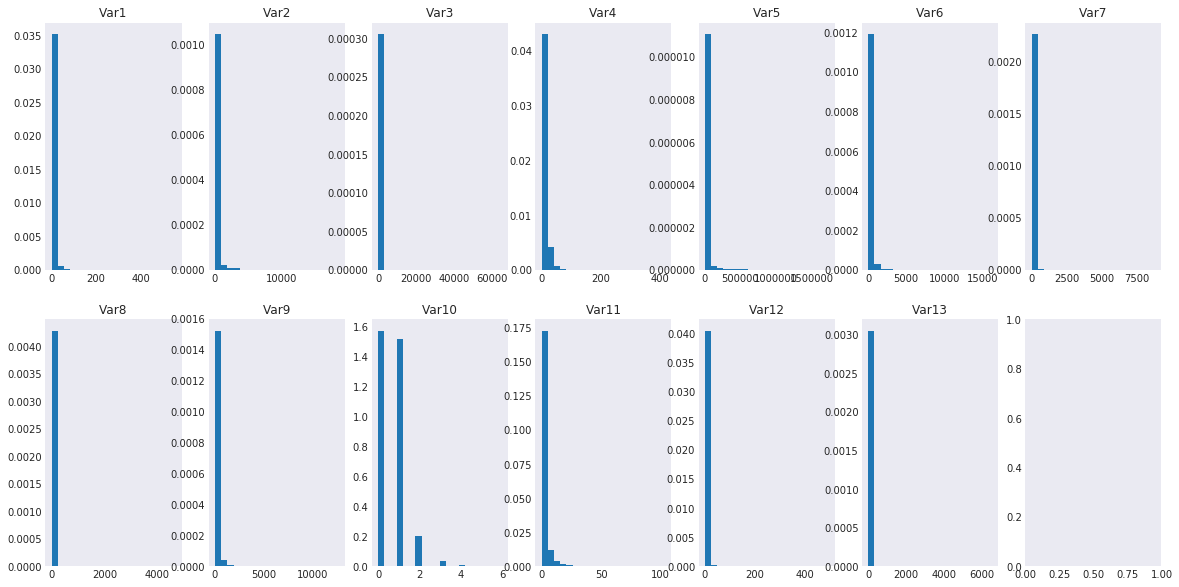

In [14]:
########
# Histogram of numerical variables 
########
# Note that the last chart is empty as we only have 13 numerical variables. 
import seaborn as sns

%matplotlib inline 
numerical_cols = ['Var1','Var2','Var3','Var4','Var5','Var6','Var7',\
                  'Var8','Var9','Var10','Var11','Var12','Var13']

fig, axs = plt.subplots(2,7, figsize=(20,10))
axs = axs.ravel()
for p in range(0,len(numerical_cols)): 
    list_values = train_sample_EDA.select(numerical_cols[p]).rdd.flatMap(lambda x: x).collect()
    cleaned_list = [x for x in list_values if x is not None]
    axs[p].hist(cleaned_list, bins=20, density=True)
    axs[p].set_title(numerical_cols[p])

## 3.3 Categorical Variables and Cardinality

* There are a total of 26 categorical columns that are also included within this dataset. 
* In Table 3.2, we immediately notice the high dimensionality when we take note of the number of distinct values in each categorical column. Some (ex: Var33 and Var22) have fewer than 5 distinct values while others (ex: Var16 and Var25) have over 10,000 distinct values. We explore our methods of preprocessing and reducing dimensionality in Section 4. 

In [15]:
categorical_cols = ['Var14','Var15','Var16','Var17','Var18','Var19','Var20','Var21','Var22',
                    'Var23','Var24','Var25','Var26','Var27','Var28','Var29','Var30','Var31',
                   'Var32','Var33','Var34','Var35','Var36','Var37','Var38','Var39']

###########
# Table 3.2: Count distinct values in each categorical column 
###########
distinct_temp = []
for column in categorical_cols: 
    distinct_temp.append({'Column':column, 'count_distinct': train_sample_EDA.select(column).distinct().count()})
    
distinct_df = pd.DataFrame(distinct_temp)
distinct_df.sort_values(by='count_distinct', ascending=False)

,Column,count_distinct
2,Var16,43870
11,Var25,41312
20,Var34,38618
15,Var29,34617
3,Var17,25184
23,Var37,12335
9,Var23,10997
25,Var39,9527
6,Var20,7623
14,Var28,5238


Given the high dimensionality of our categorical columns if we were to one hot encode so many categorical features, we wanted to know if there were certain values within the categorical variables that were more common than others, and thus would be more predictive of the final click through rate label of 1 or 0. 
* It is likely that certain values of a categorical column may be rare and therefore may not contribute much predictive power. If we were to tally up the counts of each distinct value in a categorical column (split by CTR group, or CTR == 0 vs CTR == 1) and calculate a cumulative summation of the number of observations observed per distinct value, we could distinguish just how many of the individual values within a categorical variable can cover the majority of the dataset. By further breaking down the top most frequent values in each CTR == 0 and CTR == 1 group, we can also observe which values are more telling of whether an ad will be clicked on or not. 
    * It should be noted that we defined 'majority' here as 95% of the observations within each group (CTR==0, CTR==1). 
* Furthermore, we would like to observe a sense of "correlation" between the labelled variable (CTR == 0, CTR==1) and our categorical features to see if there is any sort of association between the two variables. Pearson's Correlation unfortunately will not suffice, as we would be comparing a categorical variable (with no particular ordering) against a binary output variable that simply labels a successful/unsuccessful ad click. 
    * One particular workaround is the Cramer's V statistic (https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V): Based on the chi-squared statistic, Cramer's V is a measure of association between two nominal variables and gives an output number between 0 and 1 to quantify the strength of the association between two nominal variables. We therefore calculate Cramer's V statistic between successful/unsuccessful ad clicks (CTR==0, CTR==1) against the categorical values in each column to measure (if any) the strength of association between the two variables. 

In [16]:
##########
# Cumulative Summation 
# Intent: In each column, we want to know which values contribute the most in terms of frequency for CTR=1. 
##########

from pyspark.sql.functions import col, desc
from pyspark.sql import window
from pyspark.sql import functions as F

count_1 = train_sample_EDA.filter(col("CTR")==1).count()
count_0 = train_sample_EDA.filter(col("CTR")==0).count()

# Set aside a subset 
subset_CTR1=train_sample_EDA.filter(col("CTR")==1)[categorical_cols]
subset_CTR0=train_sample_EDA.filter(col("CTR")==0)[categorical_cols]

win_spec = (window.Window
                  .partitionBy()
                  .rowsBetween(window.Window.unboundedPreceding, 0))

top_cumsum_ctr1 = []
all_cumsum_ctr1 = []
top_cumsum_ctr0 = []
all_cumsum_ctr0 = []
summary_cumsum = []

for col in categorical_cols:
    # --- Calculate cumulative summation for CTR==1 
    tempdf = subset_CTR1.groupBy([col]).count().sort(desc('count')).cache()
    tempdf = tempdf.withColumn('count_frequ', tempdf['count']/count_1).cache()
    tempdf = tempdf.withColumn('cumsum',F.sum(tempdf.count_frequ).over(win_spec))
    all_cumsum_ctr1.append(tempdf)
    temp_pd_CTR1 = tempdf.where(tempdf.cumsum<=0.95).toPandas()
    top_cumsum_ctr1.append(temp_pd_CTR1)
    
    # --- Calculate cumulative summation for CTR==0 
    tempdf = subset_CTR0.groupBy([col]).count().sort(desc('count')).cache()
    tempdf = tempdf.withColumn('count_frequ', tempdf['count']/count_0).cache()
    tempdf = tempdf.withColumn('cumsum',F.sum(tempdf.count_frequ).over(win_spec))
    all_cumsum_ctr0.append(tempdf)
    temp_pd_CTR0 = tempdf.where(tempdf.cumsum<=0.95).toPandas()
    top_cumsum_ctr0.append(temp_pd_CTR0)
    
    # Summary stats: 
    # For each column: count up the number of distinct values that are needed to cover 95% of the observations in each group
    summary_cumsum.append({'Column': col, 'top_freq_CTR0_count': len(temp_pd_CTR0), 'top_freq_CTR1_count': len(temp_pd_CTR1)})

summary_cumsum_df = pd.DataFrame(summary_cumsum)

############
# Save the top values for each CTR group out for each categorical column 
# DO NOT run this part of the code unless you want to save out the individual CSVs. 
# These CSVs can be used for broadcasting later on. 
############ 

#for i in range(0, 26): 
#    filename = 'CTR0_'+str(categorical_cols[i])+'.csv'
#    all_cumsum_ctr0[i].toPandas().to_csv(filename, index=False)
#    filename = 'CTR1_'+str(categorical_cols[i])+'.csv'
#    all_cumsum_ctr1[i].toPandas().to_csv(filename, index=False)

In [17]:
summary_cumsum_df

,Column,top_freq_CTR0_count,top_freq_CTR1_count
0,Var14,18,18
1,Var15,185,178
2,Var16,30314,11370
3,Var17,16671,6950
4,Var18,5,5
5,Var19,4,5
6,Var20,4350,3125
7,Var21,8,9
8,Var22,1,1
9,Var23,5866,3702


In [18]:
######
# Cramer's V 
###### 

# Cramer's Value 
# referenced from https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
# and https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramers_corrected_stat(confusion_matrix): 
    """
    This function calculates the Cramer's coefficient matrix given a contingency table. 
    It has been discussed before that cramer's V can be over-optimistic in estimating association between between categories. 
    Therefore, a correction for bias has been implemented in this function as well. 
    """
    # --- get total n 
    n = np.nansum(confusion_matrix.sum()) 
    
    # --- get r,k (shape), where r = number of rows, k = number of columns 
    r,k = confusion_matrix.shape 
    
    # --- get chi-2 statistic
    chi2 = 0
    row_sums = confusion_matrix.sum(axis=1) 
    col_sums = confusion_matrix.sum(axis=0) 
    for index, row in confusion_matrix.iterrows(): 
        # index will denote the row number 
        for col in confusion_matrix.columns: # iterate across rows 
            chi2+=((row[col]-(row_sums[index]*col_sums[col]/n))**2)/(row_sums[index]*col_sums[col]/n)
    # --- get phi2 
    phi2 = chi2/n 
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) 
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

all_categorical_columns = ['Var14','Var15','Var16','Var17','Var18','Var19','Var20',\
                           'Var21','Var22','Var23','Var24','Var25','Var26','Var27',\
                           'Var28','Var29','Var30','Var31','Var32','Var33','Var34',\
                           'Var35','Var36','Var37','Var38','Var39']

def calculate_adj_cramersV_allcolumns(columns, rdd_obj): 
    """
    This function will apply Cramer's value function (cramers_corrected_stat) 
    onto the values of categorical columns in the RDD. 
    """
    cramers_df = []
    for c in columns: 
        # --- make contingency table 
        contingency = rdd_obj.map(lambda x: ((x['CTR'],x[c]),1)) \
            .reduceByKey(lambda x,y: x+y) \
            .map(lambda x: ((x[0][0],x[0][1]),x[1])).collect()
        
        # --- Unwrap contingency mapped output 
        unwrapped_df = pd.DataFrame([[contingency[i][0][0], contingency[i][0][1], \
                                    contingency[i][1]] for i in range(0, len(contingency))], \
                                    columns = ['ctr','category','count'])\
                                    .sort_values(by=['category','ctr']).reset_index(drop=True)
        
        # --- Make contingency table 
        matr_obj = pd.DataFrame(0, columns = unwrapped_df['category']\
                                .drop_duplicates().values, index = unwrapped_df['ctr']\
                                .drop_duplicates().values)
        for index, row in unwrapped_df.iterrows(): 
            matr_obj.at[row['ctr'], row['category']]=row['count']
        
        # --- Calculate Cramer's V (adjusted) 
        cramersV_value = cramers_corrected_stat(matr_obj)
        cramers_df.append({'column': c, 'cramersvalue': cramersV_value})
    return(cramers_df)

data_rdd = train_sample_EDA.rdd

all_categorical_columns = ['Var14','Var15','Var16','Var17','Var18','Var19','Var20',
                           'Var21','Var22','Var23','Var24','Var25','Var26','Var27',
                           'Var28','Var29','Var30','Var31','Var32','Var33','Var34',
                           'Var35','Var36','Var37','Var38','Var39']

cramers_results = pd.DataFrame(calculate_adj_cramersV_allcolumns(all_categorical_columns, data_rdd))\
                    .reset_index(drop=True)
cramers_results.columns=['Column','cramersvalue']

We therefore combine all of our summary statistics together. In table 3.3, for each categorical variable, we provide the 
* number of distinct values (`count_distinct`)
* number of categorical values that cover 95% of the observations in each labelled group (CTR==0 in `top_freq_CTR0_count` and CTR==1 in `top_freq_CTR1_count`). 
* percentage of observations in the categorical column that are not null (`Coverage_nonNull`). 
* Cramer's Value between the categorical column and labelled CTR variable (`Cramersvalue`). 

When sorted, we note a few things: 
* In general, it looks like columns with a lower number of distinct values tend to also have lower Cramer's coefficient with our labelled CTR variable. On the opposite end, it seems like columns with a higher number of distinct values tend to have more association with the labelled CTR variable. 
* For almost all of the categorical columns, we can see that there are fewer features that cover the majority of observations for CTR = 1 than CTR = 0. 
    * For example: For column Var25, we observe that there are 10844 categorical values (26% of all distinct values in Var25) that cover 95% or more of the observations that have a label of CTR = 1. In contrast, we see that there are 28315 categorical values (68% of all distinct values in Var25) that cover 95% or more of the observations that have a label of CTR = 0. 
    * This leads to our discussion of frequency-based reduction in dimensionality in Section 4.1.1, as it looks likely that not all individual values are needed within a column to provide prediction power. 

In [35]:
#######
# Combine summary statistics together for all categorical data 
####### 

# (1) Merge distinct counts of values for each column against the cumulative summations 
ver1 = distinct_df.merge(summary_cumsum_df, how='left', on='Column')

# (2) Merge output from (1) against percentage of non-null values for each categorical column. 
coverage_tomerge = pd.DataFrame([list(coverage_summary.index.values), list(coverage_summary['Coverage_nonNull'].values)]).T
coverage_tomerge.columns=['Column','Coverage_nonNull']
ver2 = ver1.merge(coverage_tomerge, how='left', on='Column')

# (3) Merge output from (2) against the Cramer's coefficient results 
categorical_combined_df = ver2.merge(cramers_results, how='left', on='Column')

In [37]:
########
# Table 3.3
########

categorical_combined_df['pct_topfreq_CTR0'] = categorical_combined_df['top_freq_CTR0_count']/categorical_combined_df['count_distinct']
categorical_combined_df['pct_topfreq_CTR1'] = categorical_combined_df['top_freq_CTR1_count']/categorical_combined_df['count_distinct']

categorical_combined_df.sort_values(by=['cramersvalue','Coverage_nonNull'], ascending=False)

,Column,count_distinct,top_freq_CTR0_count,top_freq_CTR1_count,Coverage_nonNull,cramersvalue,pct_topfreq_CTR0,pct_topfreq_CTR1
15,Var29,34617,23274,9441,0.96065,0.315933,0.672329,0.272727
11,Var25,41312,28315,10844,0.96065,0.312090,0.685394,0.262490
20,Var34,38618,26336,10208,0.96065,0.310233,0.681962,0.264333
2,Var16,43870,30314,11370,0.96065,0.307947,0.690996,0.259175
3,Var17,25184,16671,6950,0.96065,0.299285,0.661968,0.275969
14,Var28,5238,2135,1826,1,0.287163,0.407598,0.348606
6,Var20,7623,4350,3125,1,0.270162,0.570641,0.409944
23,Var37,12335,6635,3449,0.96065,0.269548,0.537900,0.279611
17,Var31,2548,795,811,1,0.259051,0.312009,0.318289
10,Var24,3799,2000,1534,1,0.247067,0.526454,0.403790


### 3.4 Clean-up and transforming numerical variables 

EDA reveiled the presence of negative values contained in the second numerical variable (`Var2`). Given the  interpretation of these variables as counters of some sort, a negative value appears unjustified, and as such need to be imputed. It is first noticed that `Var2` is the only numerical variable among those surveyed which does not contain null values. This may be indicative of the fact that negative values are used for this variable to effectively identify missing values.

The above being said, the relative frequency of negative numbers in this feature is estimated as approximately 10%, which is aligned with the coverage of the other numerical variables. This reinforces the interpretation of a negative value in this column as representative of missing entries.

In [22]:
train_sample_EDA.filter(train_sample_EDA["Var2"]<0).count()/train_sample_EDA.count()

0.0992

Owing to the above, it is decided to impute negative values with the average of the non-negative values of the same column.

In [23]:
from pyspark.sql.functions import avg
avgNonnegVar2 = train_sample_EDA.filter(train_sample_EDA["Var2"]>=0).agg(avg('Var2')).first()[0]
from pyspark.sql.functions import when
train_sample_EDA = train_sample_EDA.withColumn('Var2', when(train_sample_EDA['Var2']<0, avgNonnegVar2)\
                            .otherwise(train_sample_EDA.Var2))

By the same token, missing values in all other numerical columns are imputed to the average of their respective columns.

In [24]:
numerical_cols = ['Var1','Var2','Var3','Var4','Var5','Var6','Var7',\
                  'Var8','Var9','Var10','Var11','Var12','Var13']
for col in numerical_cols:
    train_sample_EDA = train_sample_EDA.na.fill(round(train_sample_EDA.na.drop().agg(avg(col)).first()[0],1), [col])

Next, a log(x+1) transformation is applied to all rows of the numerical columns. Such a transformation was chosen primarily for the log's transformation and handling of skewed data, but also getting an output of 0 when x = 0 (since log(0 + 1) = log(1) = 0).

First, a unitary value is added to all columns.

In [25]:
from pyspark.sql.functions import col
for col_add in numerical_cols:
    train_sample_EDA = train_sample_EDA.withColumn(col_add, col(col_add) + 1)

Then, the log transformation is applied.

In [26]:
from pyspark.sql.functions import log
for col_log in numerical_cols:
    train_sample_EDA = train_sample_EDA.withColumn(col_log, log(col_log))

### 3.5 Recommendations for Categorical Variables

In [193]:
# A couple options: (TBD...)

# For categorical: 
# Things to consider: (A) Cramer's value (pick only features that hit X threshold of Cramer's value)? 
# Option 1: Take the features that cover 95% of class CTR==1 only, code everything else + Null as a "lump all" category. 
# Cons of Option 1: Can we treat 'null' and 'everything else' equally? 
# Option 2: If count of a specific distinct value is < 10, we ignore that value. 
# Cons of Option 2: Doesn't exactly reduce dimensionality, especially when we have distinct values that skyrocket. 

# __Section 4__ - Algorithm Implementation

### Summary and Organization of the work

In this section, we discuss the implementation of our algorithm for Click Through Rate prediction using two different flows. 

In the first two sections (4.1 and 4.2), we discuss a homegrown implementation of the algorithm. We adopted a practical approach for our implementation which has the following steps:
- Step 1. We implement Logistic Regression with numerical variables alone
- Step 2. We add Categorical Variables into the mix and redo Logistic Regression
- Step 3. Finally we add Field Factorization Machines (FFM) and run the final model

The first section 4.1 covers Logistic Regression and FFM with numerical variables.

For the categorical variables, we investigated three different methods of reducing dimensionality based on the EDA presented above. These are covered in sections 4.2.1 through 4.2.4 

We summarize the results for a smaller dataset in 4.2.5 for the homegrown model, and pave the way for the implementation of the production pipeline in section 4.3

Sections 4.3 and 4.4 covers a pipelined version of the homegrown algorithm which we used to run the 100% dataset. The major steps in our implementation include:
- Step 1. Implementing Logistic Regression with all variables (Section 4.3)
- Step 2. Adding Field Factorization Machines (FFM) using an external Scala Library (Section 4.4)

The results of the 100% dataset are covered in this section




## 4.1 Modeling with Numerical Variables

As we mentioned in the organization of this section, we start the analysis with basic Logistic Regression using numerical variables alone in Section 4.1.1. We then do a basic FFM based model in the next section.

### 4.1.1 Logistic Regression with Numerical Variables
Add some veribiage here...@Luca

In [27]:
#generate train data for homegrown solution - select only 10000 rows and only numerical features + target 
train_sample_red = train_sample_EDA.select(['CTR'] + numerical_cols).limit(10000).cache()

In [28]:
#cache into rdd and apply log transformation
train_sample_red_RDD = train_sample_red.rdd.map(lambda x: (x[0], np.array(x[1:]))).cache()

In [29]:
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (y, features_array)
    Returns:
        normedRDD - records are tuples of (y, features_array)
    """
    featureMeans = dataRDD.map(lambda x: x[1]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[1]).variance())
    normedRDD = dataRDD.map(lambda x: (x[0], (x[1] - featureMeans)/featureStdev))

    return normedRDD

In [30]:
def LogLoss(dataRDD, W, regType = None, regParam=0.05):
    """
    Compute log loss function.
    Args:
        dataRDD - each record is a tuple of (y, features_array)
        W       - (array) model coefficients with bias at index 0
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient defaults to 0.1
    Returns:
        loss - (float) the regularized loss
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[1]), x[0])).cache()

    # add regularization term
    reg_term = 0
    if regType == 'ridge':
        reg_term = regParam*np.linalg.norm(W[1:])
    elif regType == 'lasso':
        reg_term = regParam*np.sum(np.abs(W[1:]))
        
    #broadcast model
    #W = sc.broadcast(W) #uncomment this line when deploying it on the cloud
    
    # compute loss
    loss = augmentedData.map(lambda x: x[1]*np.log(1 + np.exp(-np.dot(x[0], W))) + \
                             (1 - x[1])*(np.dot(x[0], W) + np.log(1 + np.exp(-np.dot(x[0], W))))).sum()\
                            /augmentedData.count() + reg_term
    
    return loss

def LogLoss_grad(dataRDD, W, regType = None, regParam=0.05):
    """
    Compute log loss function inside gradient descent.
    Args:
        dataRDD - each record is a tuple of (y, features_array)
        W       - (array) model coefficients with bias at index 0
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient defaults to 0.1
    Returns:
        loss - (float) the regularized loss
    """

    # add regularization term
    reg_term = 0
    if regType == 'ridge':
        reg_term = regParam*np.linalg.norm(W[1:])
    elif regType == 'lasso':
        reg_term = regParam*np.sum(np.abs(W[1:]))
    
    # compute loss
    loss = dataRDD.map(lambda x: x[1]*np.log(1 + np.exp(-np.dot(x[0], W))) + \
                             (1 - x[1])*(np.dot(x[0], W) + np.log(1 + np.exp(-np.dot(x[0], W))))).sum()\
                            /dataRDD.count() + reg_term
    
    return loss

In [31]:
def GDUpdate(trainRDD, testRDD, W, nSteps = 20, regType = None, regParam=0.05, learningRate = 0.05, verbose = False):
    """
    Perform nSteps of regularized gradient descent step/update.
    Args:
        dataRDD - records are tuples of (y, features_array)
        W       - (array) model coefficients with bias at index 0
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient defaults to 0.1
        learningRate - (float) defaults to 0.1
    Returns:
        new_model - (array) updated coefficients, bias at index 0
        training_loss (float) training loss for new_model
        test_loss (float) test loss for new_model
    """
    # add a bias 'feature' of 1 at index 0
    augmentedTrainData = trainRDD.map(lambda x: (np.append([1.0], x[1]), x[0])).cache()
    augmentedTestData = testRDD.map(lambda x: (np.append([1.0], x[1]), x[0])).cache()
    
    # compute size of training sample
    sizeTrainSample = augmentedTrainData.count()
    
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = W
    #broadcast model
    #model = sc.broadcast(W) #uncomment this line when deploying it on the cloud
    for idx in range(nSteps):
        # add regularization term
        reg_term = np.zeros(len(model))
        if regType == 'ridge':
            reg_term = np.append(0,2*regParam*model[1:])
        elif regType == 'lasso':
            reg_term = np.append(0,regParam*np.sign(model[1:]))
    
        # compute gradient
        grad = augmentedTrainData.map(lambda x: ((1/(1 + np.exp(-np.dot(x[0], model))) - x[1])*x[0]))\
               .sum()/sizeTrainSample + reg_term
    
        #update model parameters
        new_model = model - learningRate*grad
        #new_model = sc.broadcast(new_model) #uncomment this line when deploying it on the cloud
        training_loss = LogLoss_grad(augmentedTrainData, new_model, regType=regType, regParam=regParam)
        test_loss = LogLoss_grad(augmentedTestData, new_model, regType=regType, regParam=regParam)
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(new_model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[k for k in new_model]}")
        
        model = new_model
        #broadcast model
        #model = sc.broadcast(new_model) #uncomment this line when deploying it on the cloud
   
    return train_history, test_history, model_history

In [32]:
def makePrediction(dataRDD, W, treshProb=0.5):
    """
    Make predictions of target and compute number of: true positives, true negatives, 
    false positive, false negatives .
    Args:
        dataRDD - records are tuples of (y, features_array)
        W       - (array) model coefficients with bias at index 0
        treshProb- (float) threshold probability for imputation of positive labels
    Returns:
        pred - (rdd) predicted targets
        ntp - (integer) number of true positives
        ntn - (integer) number of true negatives
        nfp - (integer) number of false positives
        nfn - (integer) number of false negatives
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[1]), x[0])).cache()
    
    # compute prediction
    pred = augmentedData.map(lambda x: (int((1/(1 + np.exp(-np.dot(x[0], W))))>treshProb), x[1] )).cache()
    
    ntp = pred.map(lambda x: int((x[0]*x[1]) == 1)).sum()
    ntn = pred.map(lambda x: int((x[0]+x[1]) == 0)).sum()
    nfp = pred.map(lambda x: int((x[0] == 1) * (x[1] == 0))).sum()
    nfn = pred.map(lambda x: int((x[0] == 0) * (x[1] == 1))).sum()
   
    return pred, ntp, ntn, nfp, nfn

In [33]:
# normalize features
normedRDD = normalize(train_sample_red_RDD).cache()

In [33]:
#split into train, validation and test sets
train, validation, test = normedRDD.randomSplit([0.6, 0.2, 0.2], seed=200)

In [34]:
#compute the number of features
numb_features = len(train_sample_red.columns) - 1
#define baseline model, add one parameter representing the intercept
BASELINE = np.random.randn(numb_features + 1)

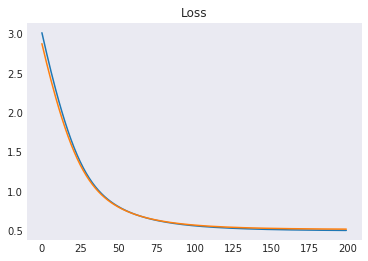

In [35]:
nSteps = 200
regType = 'ridge'
regParam = 0.05
learningRate = 0.1

# run gradient descent
train_loss, test_loss, model = GDUpdate(train, validation, BASELINE, nSteps, regType=regType, 
                                        regParam=regParam, learningRate=learningRate, verbose = False)

plt.plot(train_loss)
plt.plot(test_loss)
plt.title('Loss')
plt.show()

In [36]:
# make predictions and compute metrics for treshProb = 0.5
pred, ntp, ntn, nfp, nfn = makePrediction(validation, model[-1], 0.5)

acc = (ntp+ntn)/(ntp+ntn+nfp+nfn)
prec = (ntp)/(ntp+nfp)
rec = (ntp)/(ntp+nfn)
f1 = 2*prec*rec/(prec+rec)
fpr = nfp/(ntn+nfp)
tpr = ntp/(ntp+nfn)
print('Accuracy is: ', acc)
print('Precision is: ', prec)
print('Recall is: ', rec)
print('F1 score is: ', f1)
print('False positive rate is: ', fpr)
print('True positive rate is: ', tpr)

Accuracy is:  0.7735021919142718
Precision is:  0.5185185185185185
Recall is:  0.059957173447537475
F1 score is:  0.10748560460652591
False positive rate is:  0.01639344262295082
True positive rate is:  0.059957173447537475


0.225 :  0.5207670399299797


Text(0,0.5,'True positive rate')

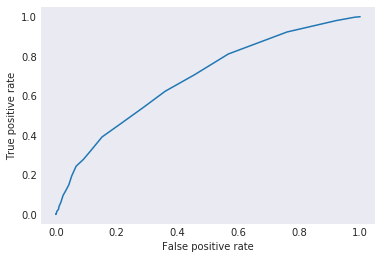

In [42]:
# generate ROC curve on validation set
tprSave = []
fprSave = []
probs = np.arange(0.0, 1.0, 0.025)
for i in probs:
    pred, ntp, ntn, nfp, nfn = makePrediction(validation, model[-1], i)
    fprSave.append(nfp/(ntn+nfp))
    tprSave.append(ntp/(ntp+nfn))

#distance from the upper-left corner of the ROC curve - the lower, the better
perf = np.sqrt((np.array(fprSave))**2+(1-np.array(tprSave))**2)
print(probs[np.argmin(perf)],': ' , np.min(perf))

plt.plot(fprSave, tprSave)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [43]:
# make predictions and compute metrics for optimal treshProb on test dataset
pred, ntp, ntn, nfp, nfn = makePrediction(test, model[-1], probs[np.argmin(perf)])

acc = (ntp+ntn)/(ntp+ntn+nfp+nfn)
prec = (ntp)/(ntp+nfp)
rec = (ntp)/(ntp+nfn)
f1 = 2*prec*rec/(prec+rec)
fpr = nfp/(ntn+nfp)
tpr = ntp/(ntp+nfn)
print('Accuracy is: ', acc)
print('Precision is: ', prec)
print('Recall is: ', rec)
print('F1 score is: ', f1)
print('False positive rate is: ', fpr)
print('True positive rate is: ', tpr)

Accuracy is:  0.6594871794871795
Precision is:  0.34413965087281795
Recall is:  0.6666666666666666
F1 score is:  0.4539473684210526
False positive rate is:  0.3424479166666667
True positive rate is:  0.6666666666666666


### Factorization Machines
Need to add verbiage here...@Sid

In [54]:
def fmLoss(dataRDD, w, w1,w0) :
    """
    Computes the logloss given the data and model W
    dataRDD - array of features, label
    """
    w_bc = sc.broadcast(w)
    w1_bc = sc.broadcast(w1)
    w0_bc = sc.broadcast(w0)
    def probability_value(x,W,W1,W0): 
        xa = np.array([x])
        V =  xa.dot(W)
        V_square = (xa*xa).dot(W*W)
        phi = 0.5*(V*V - V_square).sum() + xa.dot(W1.T) + W0
        return 1.0/(1.0 + np.exp(-phi))
    
    loss = dataRDD.map(lambda x: (x[0],x[1]) if x[0] == 1 else (-1, x[1])).map(lambda x:  (probability_value(x[1],w_bc.value, w1_bc.value, w0_bc.value), x[0])) \
        .map(lambda x: (1 - 1e-12, x[1]) if x[0] == 1 else ((1e-12, x[1]) if x[0] == 0  else (x[0],x[1]))) \
        .map(lambda x: -(x[1] * np.log(x[0]) + (1-x[1])*np.log(1-x[0]))).mean()
    
    
    return float(loss)

In [55]:
def fmGradUpdate_v1(dataRDD, w, w1, w0, alpha, regParam, regParam1, regParam0):
    """
    Computes the gradient and updates the model
    """
    
    w_bc = sc.broadcast(w)
    w1_bc = sc.broadcast(w1)
    w0_bc = sc.broadcast(w0)
    rp_bc = sc.broadcast(regParam)
    rp1_bc = sc.broadcast(regParam1)
    rp0_bc = sc.broadcast(regParam0)
    
    #Gradient for interaction term
    
    def row_grad(x, y, W, W1, W0, regParam, regParam1, regParam0):
        xa = np.array([x])
        VX =  xa.dot(W)
        VX_square = (xa*xa).dot(W*W)
        phi = 0.5*(VX*VX - VX_square).sum() + xa.dot(W1.T) + W0
        expnyt = np.exp(y*phi) 
        grad_loss = (-y/(1+expnyt))*(xa.T.dot(xa).dot(W) - np.diag(np.square(x)).dot(W))
        return 2*regParam*W + grad_loss
    
    #Gradient for Linear term
    def row_grad1(x, y, W, W1, W0, regParam, regParam1, regParam0):
        xa = np.array([x])
        VX =  xa.dot(W)
        VX_square = (xa*xa).dot(W*W)
        phi = 0.5*(VX*VX - VX_square).sum() + xa.dot(W1.T) + W0
        expnyt = np.exp(y*phi)
        grad_loss1 = (-y/(1+expnyt))*xa
        return 2*regParam1*W1 + grad_loss1
    
    #Gradient for bias term
    def row_grad0(x, y, W, W1, W0, regParam, regParam1, regParam0):
        xa = np.array([x])
        VX =  xa.dot(W)
        VX_square = (xa*xa).dot(W*W)
        phi = 0.5*(VX*VX - VX_square).sum() + xa.dot(W1.T) + W0
        expnyt = np.exp(y*phi)
        grad_loss0 = (-y/(1+expnyt))*1
        return 2*regParam0*W0 +grad_loss0
    
   
    
    batchRDD = dataRDD.sample(False, 0.01, 2019)  
    grad = batchRDD.map(lambda x: (x[0],x[1]) if x[0] == 1 else (-1, x[1])).map(lambda x: (1, row_grad(x[1], x[0], w_bc.value, w1_bc.value, w0_bc.value, rp_bc.value,rp1_bc.value,rp0_bc.value))).reduceByKey(lambda x,y: np.add(x,y))
    model = w - alpha * grad.values().collect()[0] 
    
    grad1 = batchRDD.map(lambda x: (x[0],x[1]) if x[0] == 1 else (-1, x[1])).map(lambda x: (1, row_grad1(x[1], x[0], w_bc.value, w1_bc.value, w0_bc.value, rp_bc.value,rp1_bc.value,rp0_bc.value))).reduceByKey(lambda x,y: np.add(x,y))
    model1 = w1 - alpha * grad1.values().collect()[0]
    
    grad0 = batchRDD.map(lambda x: (x[0],x[1]) if x[0] == 1 else (-1, x[1])).map(lambda x: (1, row_grad0(x[1], x[0], w_bc.value, w1_bc.value, w0_bc.value, rp_bc.value,rp1_bc.value,rp0_bc.value))).reduceByKey(lambda x,y: np.add(x,y))
    model0 = w0 - alpha * grad0.values().collect()[0]
    
    return model, model1 ,model0
    

In [56]:
def GradientDescent(trainRDD, testRDD, model, model1, model0, nSteps = 20, 
                    learningRate = 0.01, regParam = 0.01,regParam1 = 0.01,regParam0 = 0.01, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history, model1_history, model0_history = [], [], [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    model1 = wInit1
    model0 = wInit0
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        
        model, model1, model0 = fmGradUpdate_v1(trainRDD, model, model1, model0, learningRate, regParam, regParam1, regParam0)
        training_loss = fmLoss(trainRDD, model, model1, model0) 
        test_loss = fmLoss(testRDD, model, model1, model0) 
        ############## (END) YOUR CODE #############
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        model1_history.append(model1)
        model0_history.append(model0)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            #print(f"Model: {[k for k in model]}")
   
    return train_history, test_history, model_history, model1_history, model0_history

In [57]:
def wInitialization(dataRDD, factor):
    nrFeat = len(dataRDD.first()[1])
    np.random.seed(int(time.time())) 
    w =  np.random.ranf((nrFeat, factor))
    w = w / np.sqrt((w*w).sum())
    
    w1 =  np.random.ranf(nrFeat)
    w1 = w1 / np.sqrt((w1*w1).sum())
    
    w0 =  np.random.ranf(1)
    
    return w, w1, w0

In [50]:
start = time.time()
wInit, wInit1, wInit0 = wInitialization(train, 2)
logerr_train, logerr_test, models, model1s, model0s = GradientDescent(train, validation, wInit, wInit1, wInit0, nSteps = 100,
                                                    learningRate = 0.002, regParam = 0.01, regParam1 = 0.01, regParam0 = 0.01, verbose = True)

----------
STEP: 1
training loss: 1.8743559503320188
test loss: 1.9261956472225443
----------
STEP: 2
training loss: 1.7483241210940095
test loss: 1.8010982273345506
----------
STEP: 3
training loss: 1.635840857097286
test loss: 1.6897373144941283
----------
STEP: 4
training loss: 1.5338941001649127
test loss: 1.5889971445466275
----------
STEP: 5
training loss: 1.4403865133229292
test loss: 1.4967150457868597
----------
STEP: 6
training loss: 1.3538235279514386
test loss: 1.411355786813341
----------
STEP: 7
training loss: 1.2731143390149124
test loss: 1.3318040647069826
----------
STEP: 8
training loss: 1.1974439304344426
test loss: 1.2572311488438506
----------
STEP: 9
training loss: 1.1261896244750118
test loss: 1.1870079304009982
----------
STEP: 10
training loss: 1.0588656880379412
test loss: 1.1206471810970622
----------
STEP: 11
training loss: 0.995085817583462
test loss: 1.0577644159497501
----------
STEP: 12
training loss: 0.9345371872822557
test loss: 0.9980507908227664
----

The loss of the estimated model is: -0.46336344887940656




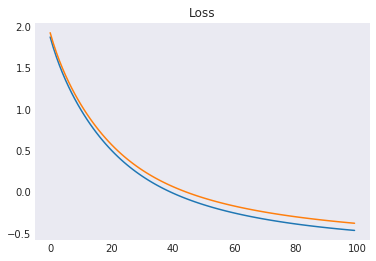

In [51]:
#print(f"The estimated model is: {models[-1]}")
print(f"The loss of the estimated model is: {logerr_train[-1]}")
print()
print()
plt.plot(logerr_train)
plt.plot(logerr_test)
plt.title('Loss')
plt.show()

In [63]:
def fmMakePrediction(dataRDD, w, w1, w0):
    """
    Perform one regularized gradient descent step/update.
    Args:
        dataRDD - records are tuples of (y, features_array)
        W       - (array) model coefficients with bias at index 0
    Returns:
        pred - (rdd) predicted targets
    """
    w_bc = sc.broadcast(w)
    w1_bc = sc.broadcast(w1)
    w0_bc = sc.broadcast(w0)
    def predict_fm(x, W, W1, W0):
        xa = np.array([x])
        VX =  xa.dot(W)
        VX_square = (xa*xa).dot(W*W)
        phi = 0.5*(VX*VX - VX_square).sum() + xa.dot(W1.T) + W0
        return 1.0/(1.0 + np.exp(-phi))
    
    # compute prediction
    pred = dataRDD.map(lambda x: (int(predict_fm(x[1],w_bc.value, w1_bc.value, w0_bc.value)>0.5), x[0] ))
    ntp = pred.map(lambda x: int((x[0]*x[1]) == 1)).sum()
    ntn = pred.map(lambda x: int((x[0]+x[1]) == 0)).sum()
    nfp = pred.map(lambda x: int((x[0] == 1) * (x[1] == 0))).sum()
    nfn = pred.map(lambda x: int((x[0] == 0) * (x[1] == 1))).sum()
   
    return pred, ntp, ntn, nfp, nfn
   
    return pred

In [53]:
pred, ntp, ntn, nfp, nfn = fmMakePrediction(validation, models[-1], model1s[-1], model0s[-1])

cc = (ntp+ntn)/(ntp+ntn+nfp+nfn)
prec = (ntp)/(ntp+nfp)
rec = (ntp)/(ntp+nfn)
f1 = 2*prec*rec/(prec+rec)
fpr = nfp/(ntn+nfp)
tpr = ntp/(ntp+nfn)
print('Accuracy is: ', acc)
print('Precision is: ', prec)
print('Recall is: ', rec)
print('F1 score is: ', f1)
print('False positive rate is: ', fpr)
print('True positive rate is: ', tpr)

Accuracy is:  0.6594871794871795
Precision is:  0.3254901960784314
Recall is:  0.1777301927194861
F1 score is:  0.22991689750692523
False positive rate is:  0.10844892812105927
True positive rate is:  0.1777301927194861


## 4.2 Adding Categorical Variables

### Summary
The earlier section showed a logistic regression model with numerical variables only. In this section, we incrementally add categorical variables and redo the logistic regression model on a small data set. Categorical variables present a challenge because each of them can have a million different values thereby creating millions of dimensions. To get around "the curse of dimensionality", we looked at quite a few methods to reduce the dimensions to a manageable level. This includes frequency based dimensionality reduction and hashing techniques at a feature level and at a collection of features. 

### "The curse of dimensionality" with categorical variables
Below, we take a look at the number of dimensions in the train_sample dataset for each categorical variable

In [5]:
# number of unique categorical values
train_sample = sc.textFile('data/train_5pct.txt')\
                 .map(lambda x: x.split('\t'))\
                 .toDF().cache()

from pyspark.sql.functions import col
distCatVarCnt = 0
for col in train_sample.columns[14:]:
    cnt = train_sample.select(col).distinct().count()
    print('Column ' + col + ' has ' + str(cnt) \
          + ' unique categorical values')
    distCatVarCnt += cnt
print("Total number of distinct categorical variables in train_sample is:", distCatVarCnt)

Column _15 has 1407 unique categorical values
Column _16 has 555 unique categorical values
Column _17 has 753315 unique categorical values
Column _18 has 258094 unique categorical values
Column _19 has 300 unique categorical values
Column _20 has 16 unique categorical values
Column _21 has 11741 unique categorical values
Column _22 has 614 unique categorical values
Column _23 has 3 unique categorical values
Column _24 has 42422 unique categorical values
Column _25 has 5126 unique categorical values
Column _26 has 661596 unique categorical values
Column _27 has 3169 unique categorical values
Column _28 has 26 unique categorical values
Column _29 has 10943 unique categorical values
Column _30 has 489035 unique categorical values
Column _31 has 10 unique categorical values
Column _32 has 4479 unique categorical values
Column _33 has 1959 unique categorical values
Column _34 has 4 unique categorical values
Column _35 has 588319 unique categorical values
Column _36 has 15 unique categorical

As we can see above, the number of unique categorical variables is close to 3 million just for the train_sample dataset. We need to look into reducing the dimensionality without losing too much of information.

### 4.2.1 Per column frequency based dimensionality reduction

One possible methold is to figure out if there are any frequent values in these categorical variables and choose the top 15 of them. If they make up nearly 100% of the values, then we can lump the rest under "Other" and come up with 16 column bins. This is a compute intensive operation as we try to figure out the top 15 values for each column and their contribution to the total count

In [8]:
train_sample_rdd = sc.textFile('data/train_5pct.txt')
#testRdd = sc.parallelize(train_sample_rdd.take(100000))

def getTop15FreqCols (rdd):
    
    #First get a count of rdd length
    rddLen = rdd.count()

    #Create pandas dataframe to store the top 15 values
    top15df = pd.DataFrame(columns=['col', 'top15_values', 'top15_pct_contribution'])

    for col in range(14,40):
        catRdd = rdd.map(lambda x: x.split('\t')[col]) \
                    .map(lambda x: (x,1)) \
                    .reduceByKey(lambda x,y: x + y)
    
        freqRecord = catRdd.takeOrdered(15, key=lambda x: -x[1])
        freqList = []
        freqCnt = 0
        for (k,v) in freqRecord:
            freqCnt += v
            freqList.append(str(k))
        top15df = top15df.append({'col': col, 'top15_values': freqList, 'top15_pct_contribution': 100*freqCnt/rddLen}, ignore_index=True)
    
    return(top15df)

top15df = getTop15FreqCols(train_sample_rdd)

#top15df = top15df.set_index('col')
    
print(top15df.to_string())

   col                                       top15_values  top15_pct_contribution
0   14  [05db9164, 68fd1e64, 5a9ed9b0, 8cf07265, be589...               93.799315
1   15  [38a947a1, 207b2d81, 38d50e09, 1cfdf714, 28713...               49.197635
2   16  [, d032c263, 02cf9876, aa8c1539, 9143c832, 77f...               15.918897
3   17  [c18be181, , 29998ed1, d16679b9, 85dd697c, 135...               22.760540
4   18  [25c83c98, 4cf72387, 43b19349, 384874ce, 30903...               98.811450
5   19  [7e0ccccf, fbad5c96, fe6b92e5, , 13718bbd, 6f6...               99.999956
6   20  [1c86e0eb, dc7659bd, 7195046d, 5e64ce5f, 468a0...               11.159026
7   21  [0b153874, 5b392875, 1f89b562, 37e4aa92, 062b5...               97.309773
8   22                     [a73ee510, 7cc72ec2, a18233ea]              100.000000
9   23  [3b08e48b, efea433b, fbbf2c95, fa7d0797, 03e48...               29.441977
10  24  [755e4a50, e51ddf94, 7f8ffe57, 4d8549da, 8b941...               16.492622
11  25  [, dfbb0

From the above analysis, we can see that the categorical variables in some of the columns account for almost 100% of all values. These include columns 14, 18, 19, 21, 22, 27, 30, 32, 33, 35, 36 and 38. For these 11 columns, it would make sense to keep the top 15 values and lump everything else under an "Other" column.

For the rest of the columns that don't exhibit this behavior, it might make sense to look at other strategies such as hashing to reduce dimensionality. Before we take this approach of using both the frequency related information and hashing, let's first take a look at hashing all columns next.

### 4.2.2 Per column Feature Hashing
There are 26 categorical features in this model represented by strings that are 8 bytes long. So, theoretically, each string can take $2^{64} -1$ different values and lead to that many dimensions. We need to have far fewer dimensions so that we can make the problem computationally achievable and as well lead to a generalized algorithm as well. One way of achieving this is through what is popularly called the "hashing trick" (provide references). 

A simple way to reduce dimensionality is to hash the 8 byte long strings into, say 16 or 32 groups. We used the murmurHash3 hashing which is generally the preferred way of hashing strings (provide references and more details). Hashing leads to collisions as many strings could end up hashing to the same hash value. However, it has been proven (references) that even with collisions, hashing leads to very generalized models.

One the categorical variables are hashed down to, say 16 values, they are then 1-hot encoded and fed into the logistic regression model. This section presents the results with the inclusion of 27 categorical variables, each individually hashed to 16 values, in addition to the numerical variables in the earlier section. 

In [9]:
#Install murmurhash3 if needed
!pip install murmurhash3
import mmh3

  Running setup.py bdist_wheel for murmurhash3 ... done
  Stored in directory: /root/.cache/pip/wheels/06/eb/e4/f57324cd9c1bf001c9ba6d6926ad5231eca80964ed80b3610e
Successfully built murmurhash3
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [34]:
categorical_cols = ['Var14','Var15','Var16','Var17','Var18','Var19','Var20','Var21','Var22',
                    'Var23','Var24','Var25','Var26','Var27','Var28','Var29','Var30','Var31',
                   'Var32','Var33','Var34','Var35','Var36','Var37','Var38','Var39']

for col in categorical_cols:
    train_sample_EDA = train_sample_EDA.na.fill('Missing', [col])

In [35]:
#generate train data for homegrown solution - select only 10000 rows of all features and target 
train_sample_red = train_sample_EDA.limit(10000).cache()

In [36]:
#cache into rdd
train_sample_red_RDD = train_sample_red.rdd.map(lambda x: (x[0], np.array(x[1:]))).cache()

In [37]:
def hashTrans (rdd):

    def createHash (elem,hlen):
        import mmh3
        hashStr = []
        for string in elem:
            hashStr.append(mmh3.hash(string) % int(hlen))
        return(hashStr)

    def create1Hot(elem, hlen):
        oneHotStr = []
        #for hashStr in elem:
        for i in range (hlen):
            if (i == elem):
                oneHotStr.append(1)
            else:
                oneHotStr.append(0)
        return(oneHotStr)

    def createCatArray(elem):
        catArray = []
        for array in elem:
            for x in array:
                catArray.append(x)
        return(np.array(catArray))

    #Define murmurHash level for 1-hot encoding
    HASHLEN = 16

    #testRdd.map(lambda x : x.split('\t')[14:40]).map(lambda x: [mmh3.hash(xn)%16 for xn in x]).take(5)
    #categoricalRdd = rdd.map(lambda x : x.split('\t')[14:40]) \
    #                    .map(lambda x: createHash(x,HASHLEN)) \
    #                    .map(lambda x: [create1Hot(xn, HASHLEN) for xn in x]) \
    #                    .map(createCatArray)
    
    categoricalRdd = rdd.map(lambda x : x[1][14:]) \
                        .map(lambda x: createHash(x,HASHLEN)) \
                        .map(lambda x: [create1Hot(xn, HASHLEN) for xn in x]) \
                        .map(createCatArray)
    
    return(categoricalRdd)

categoricalRdd = hashTrans(train_sample_red_RDD)

In [38]:
#Now include this into the logistic regression model
#Zip numerical and categorical variables

def mergeNumPlusCatRdds(elem):
    x, y = elem
    xkey , xval = x
    merge =  (xkey, np.hstack((xval,y)))
    return(merge)

numPlusCatRdd = normedRDD.zip(categoricalRdd) \
                         .map(mergeNumPlusCatRdds)

In [39]:
#compute the number of features
numb_features = np.size(numPlusCatRdd.first()[1])
print(numb_features)
#define baseline model, add one parameter representing the intercept
BASELINE = np.random.randn(numb_features + 1)

413


In [40]:
#split into train, validation and test sets
train, validation, test = numPlusCatRdd.randomSplit([0.6, 0.2, 0.2], seed=200)

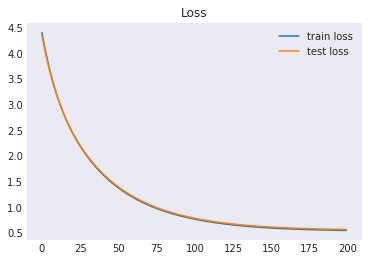

In [41]:
nSteps = 200
regType = 'ridge'
regParam = 0.1
learningRate = 0.1

# run gradient descent
train_loss, test_loss, model = GDUpdate(train, validation, BASELINE, nSteps, regType=regType, 
                                        regParam=regParam, learningRate=learningRate, verbose = False)

plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [42]:
# make predictions and compute metrics for treshProb = 0.22
pred, ntp, ntn, nfp, nfn = makePrediction(validation, model[-1], 0.22)

acc = (ntp+ntn)/(ntp+ntn+nfp+nfn)
prec = (ntp)/(ntp+nfp)
rec = (ntp)/(ntp+nfn)
f1 = 2*prec*rec/(prec+rec)
fpr = nfp/(ntn+nfp)
tpr = ntp/(ntp+nfn)
print('Accuracy is: ', acc)
print('Precision is: ', prec)
print('Recall is: ', rec)
print('F1 score is: ', f1)
print('False positive rate is: ', fpr)
print('True positive rate is: ', tpr)

Accuracy is:  0.5479785679493424
Precision is:  0.3048264182895851
Recall is:  0.7708779443254818
F1 score is:  0.43689320388349523
False positive rate is:  0.5176544766708702
True positive rate is:  0.7708779443254818


0.5251742370564151


Text(0,0.5,'True positive rate')

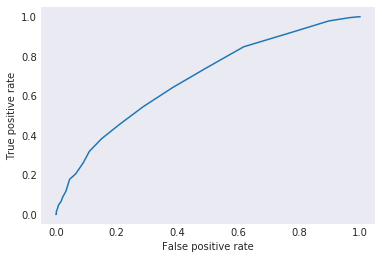

In [43]:
# generate ROC curve
tprSave = []
fprSave = []
for i in np.arange(0.0, 1.0, 0.025):
    pred, ntp, ntn, nfp, nfn = makePrediction(validation, model[-1], i)
    fprSave.append(nfp/(ntn+nfp))
    tprSave.append(ntp/(ntp+nfn))

#distance from the upper-left corner of the ROC curve - the lower, the better
perf = np.sqrt((np.array(fprSave))**2+(1-np.array(tprSave))**2)
print(np.min(perf))

plt.plot(fprSave, tprSave)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [44]:
fprSave_ridge = fprSave
tprSave_ridge = tprSave

One model fit with lasso allowed us to identify what appear to be the most important features in this dataset. These were selected, somewhat arbitrarily, as the features whose absolute value of the coefficient was, after training, higher than $0.01$, together with the features immediately next to these. These features, $32$ in total, were utilized to train yet another ridge-regularized logistic regression model.

In [45]:
columns_sel = [4,5,6,9,10,11,12,61,62,63,72,73,74,119,120,121,122,133,134,135,160,161,162,308,309,310,404,405,406,407,408,409]
numPlusCatRdd_sel = numPlusCatRdd.map(lambda x: (x[0], np.array([x[1][i] for i in columns_sel])))

In [46]:
#compute the number of features
numb_features = np.size(numPlusCatRdd_sel.first()[1])
print(numb_features)
#define baseline model, add one parameter representing the intercept
BASELINE = np.random.randn(numb_features + 1)

32


In [47]:
#split into train, validation and test sets
train, validation, test = numPlusCatRdd_sel.randomSplit([0.6, 0.2, 0.2], seed=200)

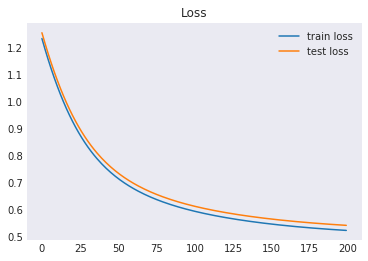

In [48]:
nSteps = 200
regType = 'ridge'
regParam = 0.05
learningRate = 0.1

# run gradient descent
train_loss, test_loss, model = GDUpdate(train, validation, BASELINE, nSteps, regType=regType, 
                                        regParam=regParam, learningRate=learningRate, verbose = False)

plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [49]:
# make predictions and compute metrics for treshProb = 0.5
pred, ntp, ntn, nfp, nfn = makePrediction(validation, model[-1], 0.5)

acc = (ntp+ntn)/(ntp+ntn+nfp+nfn)
prec = (ntp)/(ntp+nfp)
rec = (ntp)/(ntp+nfn)
f1 = 2*prec*rec/(prec+rec)
fpr = nfp/(ntn+nfp)
tpr = ntp/(ntp+nfn)
print('Accuracy is: ', acc)
print('Precision is: ', prec)
print('Recall is: ', rec)
print('F1 score is: ', f1)
print('False positive rate is: ', fpr)
print('True positive rate is: ', tpr)

Accuracy is:  0.7754505601558694
Precision is:  0.5681818181818182
Recall is:  0.05353319057815846
F1 score is:  0.09784735812133073
False positive rate is:  0.01197982345523329
True positive rate is:  0.05353319057815846


0.5374047045277943


Text(0,0.5,'True positive rate')

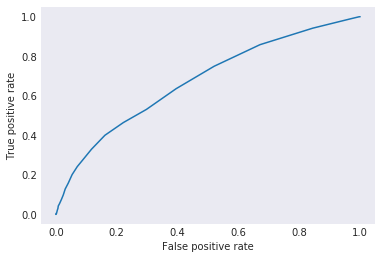

In [50]:
# generate ROC curve
tprSave = []
fprSave = []
for i in np.arange(0.0, 1.0, 0.025):
    pred, ntp, ntn, nfp, nfn = makePrediction(validation, model[-1], i)
    fprSave.append(nfp/(ntn+nfp))
    tprSave.append(ntp/(ntp+nfn))

#distance from the upper-left corner of the ROC curve - the lower, the better
perf = np.sqrt((np.array(fprSave))**2+(1-np.array(tprSave))**2)
print(np.min(perf))

plt.plot(fprSave, tprSave)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [51]:
fprSave_ridge_red = fprSave
tprSave_ridge_red = tprSave

The plot below offers a comparison between the ROC curves as obtained with model trained on the full dataset and the model trained on the reduced dataset, respectively.  

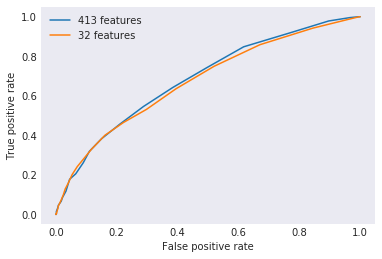

In [52]:
plt.plot(fprSave_ridge,tprSave_ridge, label='413 features')
plt.plot(fprSave_ridge_red,tprSave_ridge_red, label='32 features')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

#### Factorization Machine

In [58]:
start = time.time()
wInit, wInit1, wInit0 = wInitialization(train, 2)
#print(wInit)
logerr_train, logerr_test, models_cat, model1s_cat, model0s_cat = GradientDescent(train, validation, wInit,wInit1, wInit0, nSteps = 100,
                                                    learningRate = 0.001, regParam = 0.01, regParam1 = 0.01, regParam0 = 0.01, verbose = True)

----------
STEP: 1
training loss: 1.6600936348362
test loss: 1.640705159197655
----------
STEP: 2
training loss: 1.6149438147030717
test loss: 1.5973876049852864
----------
STEP: 3
training loss: 1.5709047129599172
test loss: 1.5551196612965654
----------
STEP: 4
training loss: 1.5279545296228552
test loss: 1.5138808069128842
----------
STEP: 5
training loss: 1.4860706814649163
test loss: 1.4736498261868902
----------
STEP: 6
training loss: 1.4452299454135797
test loss: 1.4344049375700063
----------
STEP: 7
training loss: 1.4054085964157568
test loss: 1.3961239175667135
----------
STEP: 8
training loss: 1.366582538332149
test loss: 1.3587842187340746
----------
STEP: 9
training loss: 1.328727426758355
test loss: 1.3223630806436657
----------
STEP: 10
training loss: 1.291818782983446
test loss: 1.2868376330119047
----------
STEP: 11
training loss: 1.2558320985812528
test loss: 1.2521849904726974
----------
STEP: 12
training loss: 1.2207429303807644
test loss: 1.2183823387061066
--------

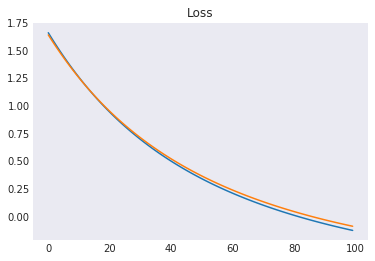

In [62]:
#print(f"The estimated model is: {models[-1]}")
#print(f"The loss of the estimated model is: {logerr_train[-1]}")
print()
print()
plt.plot(logerr_train)
plt.plot(logerr_test)
plt.title('Loss')
plt.show()

In [65]:
pred, ntp, ntn, nfp, nfn = fmMakePrediction(validation, models_cat[-1], model1s_cat[-1], model0s_cat[-1])

cc = (ntp+ntn)/(ntp+ntn+nfp+nfn)
prec = (ntp)/(ntp+nfp)
rec = (ntp)/(ntp+nfn)
f1 = 2*prec*rec/(prec+rec)
fpr = nfp/(ntn+nfp)
tpr = ntp/(ntp+nfn)
print('Accuracy is: ', acc)
print('Precision is: ', prec)
print('Recall is: ', rec)
print('F1 score is: ', f1)
print('False positive rate is: ', fpr)
print('True positive rate is: ', tpr)

Accuracy is:  0.7754505601558694
Precision is:  0.372972972972973
Recall is:  0.14775160599571735
F1 score is:  0.21165644171779144
False positive rate is:  0.07313997477931904
True positive rate is:  0.14775160599571735


### 4.2.3 Multi-column Feature Hashing
Hashing each column independently resulted in a dimensionality reduction from several million vectors to 416 for the categorical variables. We could further reduce dimensionality through multi-column Feature Hashing with a likely tradeoff being the loss of accuracy (TBD). 

We used the multi-column FeatureHashing functionality in Apache Spark MLLib to look into how dimensionality reduction to fewer vectors for logistic regression. Multi-column FeatureHashing would be very handy when we start looking at adding in quadratic terms for logistic regression. Instead of a (416,416) quadratic feature matrix, we could deal with a smaller (32,32) or (64,64) features, leading to faster computation.

#### Spark MLLib FeatureHasher example
The FeatureHasher in spark takes multiple columns of categorical (and numerical) variables and hashes them down to fewer features. It is possible to specify the number of output features so that we can restrict the dimensions to a more manageable number.

In [66]:
#Feature hashing example
from pyspark.ml.feature import FeatureHasher

dataset = spark.createDataFrame([
    (2.2, True, "1", "foo"),
    (3.3, False, "2", "bar"),
    (4.4, False, "3", "baz"),
    (5.5, False, "4", "foo")
], ["real", "bool", "stringNum", "string"])

hasher = FeatureHasher(inputCols=["real", "bool", "stringNum", "string"],
                       outputCol="features")

featurized = hasher.transform(dataset)
featurized.select("features").show(truncate=False)

+--------------------------------------------------------+
|features                                                |
+--------------------------------------------------------+
|(262144,[174475,247670,257907,262126],[2.2,1.0,1.0,1.0])|
|(262144,[70644,89673,173866,174475],[1.0,1.0,1.0,3.3])  |
|(262144,[22406,70644,174475,187923],[1.0,1.0,4.4,1.0])  |
|(262144,[70644,101499,174475,257907],[1.0,1.0,5.5,1.0]) |
+--------------------------------------------------------+



#### Multi-column Feature Hashing
We applied Multi-column Feature Hashing to get to a dimensionality of 64 vectors using FeatureHasher. The results of the logistic regression following this hashing are given below 

In [67]:
#generate train data for homegrown solution - select only 10000 rows of all features and target 
train_sample_red = train_sample_EDA.limit(10000).cache()

In [68]:
#cache into rdd
train_sample_red_RDD = train_sample_red.rdd.map(lambda x: (x[0], np.array(x[1:]))).cache()

In [69]:
#choose categorical columns to Hash
hashInpList = []
for c in categorical_cols:
    hashInpList.append(c)
print (hashInpList)

['Var14', 'Var15', 'Var16', 'Var17', 'Var18', 'Var19', 'Var20', 'Var21', 'Var22', 'Var23', 'Var24', 'Var25', 'Var26', 'Var27', 'Var28', 'Var29', 'Var30', 'Var31', 'Var32', 'Var33', 'Var34', 'Var35', 'Var36', 'Var37', 'Var38', 'Var39']


In [70]:
#Apply Multi-column hashing with given output features
numFeatures = 256 #tried 50, 100, 256, 400
hasher = FeatureHasher(numFeatures=numFeatures, inputCols=hashInpList,outputCol="features")

featurized = hasher.transform(train_sample_red)
featurized.select("features").show(3,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                 |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(256,[8,16,20,39,60,62,66,71,82,84,107,111,113,125,131,146,163,165,190,193,201,220,226,228,232],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0])   |
|(256,[9,12,25,34,39,41,62,79,107,108,111,113,121,122,141,194,201,202,211,219,228,248],[1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0])       

In [71]:
featurized.show(3)
featurized.rdd.getNumPartitions()

+---+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------------------+
|CTR|              Var1|              Var2|              Var3|              Var4|             Var5|              Var6|              Var7|              Var8|              Var9|             Var10|             Var11|             Var12|             Var13|   Var14|   Var15|   Var16|   Var17|   Var18|   Var19|   Var20|   Var21|   Var22|   Var23|   Var24|   Var25|   Var26|   Var27|   Var28|   Var29|   Var30|   Var31|   Var32|   Var33|   Var34|   Var35|   Var36|   Var37|   Var38|   Var39|        

1

In [72]:
#Convert into a dense vector format to feed logistic regression model
def extractVec (elem):
    return(np.array(tuple(elem.features.toArray().tolist())))
    
multiHashCatRdd = featurized.select("features").rdd.map(extractVec)
#map(extractVec)
multiHashCatRdd.take(3)
multiHashCatRdd.getNumPartitions()

1

In [73]:
featurized.show(3)

+---+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------------------+
|CTR|              Var1|              Var2|              Var3|              Var4|             Var5|              Var6|              Var7|              Var8|              Var9|             Var10|             Var11|             Var12|             Var13|   Var14|   Var15|   Var16|   Var17|   Var18|   Var19|   Var20|   Var21|   Var22|   Var23|   Var24|   Var25|   Var26|   Var27|   Var28|   Var29|   Var30|   Var31|   Var32|   Var33|   Var34|   Var35|   Var36|   Var37|   Var38|   Var39|        

In [74]:
#Now include this into the logistic regression model
#Zip numerical and categorical variables

def mergeNumPlusCatRdds(elem):
    x, y = elem
    xkey , xval = x
    merge =  (xkey, np.hstack((xval,y)))
    return(merge)

numPlusCatRdd2 = normedRDD.zip(multiHashCatRdd) \
                         .map(mergeNumPlusCatRdds)
numPlusCatRdd2.take(1)
numPlusCatRdd2.getNumPartitions()

1

In [75]:
#compute the number of features
numb_features = np.size(numPlusCatRdd2.first()[1])
print(numb_features)
#define baseline model, add one parameter representing the intercept
BASELINE = np.random.randn(numb_features + 1)


269


In [76]:
#split into train, validation and test sets
train, validation, test = numPlusCatRdd2.randomSplit([0.6, 0.2, 0.2], seed=200)

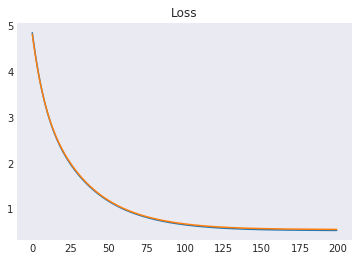

In [77]:
nSteps = 200
regType = 'ridge'
regParam = 0.12
learningRate = 0.1

# run gradient descent
train_loss, test_loss, model = GDUpdate(train, validation, BASELINE, nSteps, regType=regType, 
                                        regParam=regParam, learningRate=learningRate, verbose = False)

plt.plot(train_loss)
plt.plot(test_loss)
plt.title('Loss')
plt.show()

In [78]:
# make predictions and compute metrics for treshProb = 0.5
pred, ntp, ntn, nfp, nfn = makePrediction(validation, model[-1], 0.5)

acc = (ntp+ntn)/(ntp+ntn+nfp+nfn)
prec = (ntp)/(ntp+nfp)
rec = (ntp)/(ntp+nfn)
f1 = 2*prec*rec/(prec+rec)
fpr = nfp/(ntn+nfp)
tpr = ntp/(ntp+nfn)
print('Accuracy is: ', acc)
print('Precision is: ', prec)
print('Recall is: ', rec)
print('F1 score is: ', f1)
print('False positive rate is: ', fpr)
print('True positive rate is: ', tpr)

Accuracy is:  0.77496346809547
Precision is:  0.5862068965517241
Recall is:  0.03640256959314775
F1 score is:  0.0685483870967742
False positive rate is:  0.007566204287515763
True positive rate is:  0.03640256959314775


0.25 :  0.5315682150233095


Text(0,0.5,'True positive rate')

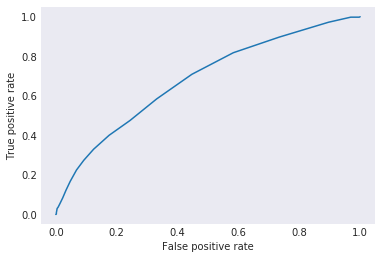

In [79]:
# generate ROC curve on validation set
tprSave = []
fprSave = []
probs = np.arange(0.0, 1.0, 0.025)
for i in probs:
    pred, ntp, ntn, nfp, nfn = makePrediction(validation, model[-1], i)
    fprSave.append(nfp/(ntn+nfp))
    tprSave.append(ntp/(ntp+nfn))

#distance from the upper-left corner of the ROC curve - the lower, the better
perf = np.sqrt((np.array(fprSave))**2+(1-np.array(tprSave))**2)
print(probs[np.argmin(perf)],': ' , np.min(perf))

plt.plot(fprSave, tprSave)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [80]:
# make predictions and compute metrics for optimal treshProb on test dataset
pred, ntp, ntn, nfp, nfn = makePrediction(test, model[-1], probs[np.argmin(perf)])

acc = (ntp+ntn)/(ntp+ntn+nfp+nfn)
prec = (ntp)/(ntp+nfp)
rec = (ntp)/(ntp+nfn)
f1 = 2*prec*rec/(prec+rec)
fpr = nfp/(ntn+nfp)
tpr = ntp/(ntp+nfn)
print('Accuracy is: ', acc)
print('Precision is: ', prec)
print('Recall is: ', rec)
print('F1 score is: ', f1)
print('False positive rate is: ', fpr)
print('True positive rate is: ', tpr)

Accuracy is:  0.6723076923076923
Precision is:  0.35177865612648224
Recall is:  0.644927536231884
F1 score is:  0.4552429667519182
False positive rate is:  0.3203125
True positive rate is:  0.644927536231884


### Factorization machine

In [ ]:
start = time.time()
wInit, wInit1, wInit0 = wInitialization(train, 2)
#print(wInit)
logerr_train, logerr_test, models_cat2, model1s_cat2, model0s_cat2 = GradientDescent(train, validation, wInit,wInit1, wInit0, nSteps = 100,
                                                    learningRate = 0.001, regParam = 0.01, regParam1 = 0.01, regParam0 = 0.01, verbose = True)

In [ ]:
print(f"The estimated model is: {models[-1]}")
print(f"The loss of the estimated model is: {logerr_train[-1]}")
print()
print()
plt.plot(logerr_train)
plt.plot(logerr_test)
plt.title('Loss')
plt.show()

In [ ]:
pred, ntp, ntn, nfp, nfn = fmMakePrediction(validation, models[-1], model1s[-1], model0s[-1])

cc = (ntp+ntn)/(ntp+ntn+nfp+nfn)
prec = (ntp)/(ntp+nfp)
rec = (ntp)/(ntp+nfn)
f1 = 2*prec*rec/(prec+rec)
fpr = nfp/(ntn+nfp)
tpr = ntp/(ntp+nfn)
print('Accuracy is: ', acc)
print('Precision is: ', prec)
print('Recall is: ', rec)
print('F1 score is: ', f1)
print('False positive rate is: ', fpr)
print('True positive rate is: ', tpr)

### 4.2.4 Combining Frequency and Hash Based Dimensionality Reduction
For some categorical features, it makes sense to use a frequency based approach, while hashing is useful in other cases. 12 of the columns were amenable to frequency based approaches since 90% or more of the values were accounted for by the top 15 frequent values. The hybrid approach uses frequencies to encode these columns, while using the hash only for the other 14 columns.

In [103]:
def hybridFreqHashTrans (top15df, rdd):

    #First create Broadcast variable
    top15dfB = sc.broadcast(top15df)
    
    #set FreqThr at 90% for using frequency to bin the categories
    TOP15_FREQ_THR = 90

    #Define murmurHash level for 1-hot encoding
    HASHLEN = 16
    
    #top15df = pd.DataFrame(columns=['col', 'top15_values', 'top15_pct_contribution'])
    
    def transformRow (row, top15df, hlen):
        col = 0
        transformedRow = []
        
        for x in row:
            #Get frequency based map
            if (top15df.loc[col]['top15_pct_contribution'] > 90):
                xtrans = 15
                for (ind,topElem) in enumerate(top15df.loc[col]['top15_values']):
                    if (x == topElem):
                        xtrans = ind
            #else hash
            else:
                xtrans = mmh3.hash(x+str(col)) % int(hlen)
        
            transformedRow.append(xtrans)
            
            #Do this for all elements
            col += 1
        return (transformedRow)

    def create1Hot(elem, hlen):
        oneHotStr = []
        #for hashStr in elem:
        for i in range (hlen):
            if (i == elem):
                oneHotStr.append(1)
            else:
                oneHotStr.append(0)
        return(oneHotStr)

    def createCatArray(elem):
        catArray = []
        for array in elem:
            for x in array:
                catArray.append(x)
        return(np.array(catArray))



    categoricalRdd = rdd.map(lambda x : x.split('\t')[14:40]) \
                        .map(lambda x: transformRow(x, top15dfB.value, HASHLEN)) \
                        .map(lambda x: [create1Hot(xn, HASHLEN) for xn in x]) \
                        .map(createCatArray)
    return(categoricalRdd)

#Read in the complete dataset
train_sample_rdd = sc.textFile('data/sample_training.txt')

#Get the top 1000 rows only (as before for numerical variables)
testRdd = sc.parallelize(train_sample_rdd.take(10000),1)

hybridCatRdd = hybridFreqHashTrans(top15df, testRdd)

hybridCatRdd.take(1)

[array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [100]:
#Now include this into the logistic regression model
#Zip numerical and categorical variables

def mergeNumPlusCatRdds(elem):
    x, y = elem
    xkey , xval = x
    merge =  (xkey, np.hstack((xval,y)))
    return(merge)

numPlusCatRdd3 = normedRDD.zip(hybridCatRdd) \
                         .map(mergeNumPlusCatRdds)
numPlusCatRdd3.take(1)

[(0.0, array([-0.45879823, -0.24774127, -0.04629014, -0.85019922, -0.24482546,
         -0.40934022, -0.02096037, -0.63143545,  0.18286248,  0.7486028 ,
         -0.10449796,  0.01324891, -0.49600354,  0.        ,  1.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        

In [95]:
#compute the number of features
numb_features = np.size(numPlusCatRdd3.first()[1])
print(numb_features)
#define baseline model, add one parameter representing the intercept
BASELINE = np.random.randn(numb_features + 1)

429


In [96]:
#split into train, validation and test sets
train, validation, test = numPlusCatRdd3.randomSplit([0.6, 0.2, 0.2])

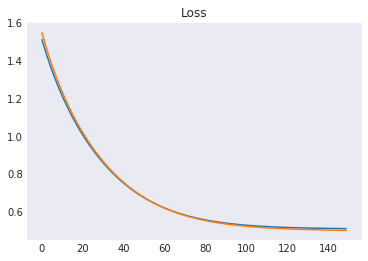

In [101]:
nSteps = 150
regType = 'ridge'
regParam = 0.1
learningRate = 0.1

# run gradient descent
train_loss, test_loss, model = GDUpdate(train, validation, BASELINE, nSteps, regType=regType, 
                                        regParam=regParam, learningRate=learningRate, verbose = False)

plt.plot(train_loss)
plt.plot(test_loss)
plt.title('Loss')
plt.show()

In [102]:
# make predictions and compute metrics for treshProb = 0.5
pred, ntp, ntn, nfp, nfn = makePrediction(validation, model[-1], 0.5)

acc = (ntp+ntn)/(ntp+ntn+nfp+nfn)
prec = (ntp)/(ntp+nfp)
rec = (ntp)/(ntp+nfn)
f1 = 2*prec*rec/(prec+rec)
fpr = nfp/(ntn+nfp)
tpr = ntp/(ntp+nfn)
print('Accuracy is: ', acc)
print('Precision is: ', prec)
print('Recall is: ', rec)
print('F1 score is: ', f1)
print('False positive rate is: ', fpr)
print('True positive rate is: ', tpr)

Accuracy is:  0.7901541521631029
Precision is:  0.47619047619047616
Recall is:  0.023752969121140142
F1 score is:  0.04524886877828054
False positive rate is:  0.006918238993710692
True positive rate is:  0.023752969121140142


In [ ]:
start = time.time()
wInit, wInit1, wInit0 = wInitialization(train, 2)
logerr_train, logerr_test, models, model1s, model0s = GradientDescent(train, validation, wInit, wInit1, wInit0, nSteps = 100,
                                                    learningRate = 0.002, regParam = 0.01, regParam1 = 0.01, regParam0 = 0.01, verbose = True)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")

In [ ]:
print(f"The estimated model is: {models[-1]}")
print(f"The loss of the estimated model is: {logerr_train[-1]}")
print()
print()
plt.plot(logerr_train)
plt.plot(logerr_test)
plt.title('Loss')
plt.show()

In [ ]:
pred, ntp, ntn, nfp, nfn = fmMakePrediction(validation, models[-1], model1s[-1], model0s[-1])

cc = (ntp+ntn)/(ntp+ntn+nfp+nfn)
prec = (ntp)/(ntp+nfp)
rec = (ntp)/(ntp+nfn)
f1 = 2*prec*rec/(prec+rec)
fpr = nfp/(ntn+nfp)
tpr = ntp/(ntp+nfn)
print('Accuracy is: ', acc)
print('Precision is: ', prec)
print('Recall is: ', rec)
print('F1 score is: ', f1)
print('False positive rate is: ', fpr)
print('True positive rate is: ', tpr)

## 4.3 Production Pipeline
Add summary etc (Venky)

### 4.3.1 Important articles to look at

https://towardsdatascience.com/apache-spark-mllib-tutorial-7aba8a1dce6e

https://stackoverflow.com/questions/32982425/encode-and-assemble-multiple-features-in-pyspark

https://blog.insightdatascience.com/spark-pipelines-elegant-yet-powerful-7be93afcdd42

https://medium.com/future-vision/spark-udfs-we-can-use-them-but-should-we-use-them-2c5a561fde6d

### 4.3.2 Basic pipeline based production model for Logistic Regression
Venky to add details

In [84]:
#Read in dataframe - this is the tiny dataset with 100K lines
df = sc.textFile('data/sample_training.txt')\
                 .map(lambda x: x.split('\t'))\
                 .toDF().cache()
df.show(2)

+---+---+---+---+---+----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+--------+--------+--------+--------+
| _1| _2| _3| _4| _5|  _6| _7| _8| _9|_10|_11|_12|_13|_14|     _15|     _16|     _17|     _18|     _19|     _20|     _21|     _22|     _23|     _24|     _25|     _26|     _27|     _28|     _29|     _30|     _31|     _32|     _33|     _34|     _35|_36|     _37|     _38|     _39|     _40|
+---+---+---+---+---+----+---+---+---+---+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+--------+--------+--------+--------+
|  0|  1|  1|  5|  0|1382|  4| 15|  2|181|  1|  2|   |  2|68fd1e64|80e26c9b|fb936136|7b4723c4|25c83c98|7e0ccccf|de7995b8|1f89b562|a73ee5

In [85]:
# Define categorical and numerical columns
categoricalCols = []
numericalCols = []
numericalColsImputed = []
numericalColsLog = []
for c in range(2,41):
    col = "_"+str(c)
    colImp = str(c)+"_imp"
    colLog = str(c)+"_log"
    if (c < 15):
        numericalCols.append(col)
        numericalColsImputed.append(colImp)
        numericalColsLog.append(colLog)
    else:
        categoricalCols.append(col)

In [86]:
df.select(numericalCols).show(10)

+---+---+---+---+-----+---+---+---+---+---+---+---+---+
| _2| _3| _4| _5|   _6| _7| _8| _9|_10|_11|_12|_13|_14|
+---+---+---+---+-----+---+---+---+---+---+---+---+---+
|  1|  1|  5|  0| 1382|  4| 15|  2|181|  1|  2|   |  2|
|  2|  0| 44|  1|  102|  8|  2|  2|  4|  1|  1|   |  4|
|  2|  0|  1| 14|  767| 89|  4|  2|245|  1|  3|  3| 45|
|   |893|   |   | 4392|   |  0|  0|  0|   |  0|   |   |
|  3| -1|   |  0|    2|  0|  3|  0|  0|  1|  1|   |  0|
|   | -1|   |   |12824|   |  0|  0|  6|   |  0|   |   |
|   |  1|  2|   | 3168|   |  0|  1|  2|   |  0|   |   |
|  1|  4|  2|  0|    0|  0|  1|  0|  0|  1|  1|   |  0|
|   | 44|  4|  8|19010|249| 28| 31|141|   |  1|   |  8|
|   | 35|   |  1|33737| 21|  1|  2|  3|   |  1|   |  1|
+---+---+---+---+-----+---+---+---+---+---+---+---+---+
only showing top 10 rows



In [87]:
stages = [] # stages in our Pipeline

In [88]:
from pyspark.sql.functions import when
for col in numericalCols:
    df = df.withColumn(col, df[col].cast("double"))
    df= df.withColumn(col, when(df[col]<0, None).otherwise(df[col]))
#Also do this for column 0
df = df.withColumn("_1", df["_1"].cast("double"))

In [89]:
#Confirming that numerical columns with -1s etc are changed to Null
df.select(numericalCols).show(10)

+----+-----+----+----+-------+-----+----+----+-----+----+---+----+----+
|  _2|   _3|  _4|  _5|     _6|   _7|  _8|  _9|  _10| _11|_12| _13| _14|
+----+-----+----+----+-------+-----+----+----+-----+----+---+----+----+
| 1.0|  1.0| 5.0| 0.0| 1382.0|  4.0|15.0| 2.0|181.0| 1.0|2.0|null| 2.0|
| 2.0|  0.0|44.0| 1.0|  102.0|  8.0| 2.0| 2.0|  4.0| 1.0|1.0|null| 4.0|
| 2.0|  0.0| 1.0|14.0|  767.0| 89.0| 4.0| 2.0|245.0| 1.0|3.0| 3.0|45.0|
|null|893.0|null|null| 4392.0| null| 0.0| 0.0|  0.0|null|0.0|null|null|
| 3.0| null|null| 0.0|    2.0|  0.0| 3.0| 0.0|  0.0| 1.0|1.0|null| 0.0|
|null| null|null|null|12824.0| null| 0.0| 0.0|  6.0|null|0.0|null|null|
|null|  1.0| 2.0|null| 3168.0| null| 0.0| 1.0|  2.0|null|0.0|null|null|
| 1.0|  4.0| 2.0| 0.0|    0.0|  0.0| 1.0| 0.0|  0.0| 1.0|1.0|null| 0.0|
|null| 44.0| 4.0| 8.0|19010.0|249.0|28.0|31.0|141.0|null|1.0|null| 8.0|
|null| 35.0|null| 1.0|33737.0| 21.0| 1.0| 2.0|  3.0|null|1.0|null| 1.0|
+----+-----+----+----+-------+-----+----+----+-----+----+---+---

In [90]:
#Pipeline Stages- 6 of them
#Stage 1 - First transform numerical columns with imputer
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=numericalCols, outputCols=numericalColsImputed)
stages += [imputer]
imputer_model = imputer.fit(df)

#Stage 2 - Compute log transforms
from pyspark.ml.feature import SQLTransformer
sqlTrans = SQLTransformer(statement="SELECT *, \
                          log(2_imp+1) AS 2_log, \
                          log(3_imp+1) AS 3_log, \
                          log(4_imp+1) AS 4_log, \
                          log(5_imp+1) AS 5_log, \
                          log(6_imp+1) AS 6_log, \
                          log(7_imp+1) AS 7_log, \
                          log(8_imp+1) AS 8_log, \
                          log(9_imp+1) AS 9_log, \
                          log(10_imp+1) AS 10_log, \
                          log(11_imp+1) AS 11_log, \
                          log(12_imp+1) AS 12_log, \
                          log(13_imp+1) AS 13_log, \
                          log(14_imp+1) AS 14_log \
                          FROM __THIS__")
stages += [sqlTrans]

#Stage 3 - Assemble the column vectors
from pyspark.ml.feature import VectorAssembler
numericalAssembler = VectorAssembler(inputCols=numericalColsLog, outputCol="log_numerical_feature_vec")
stages += [numericalAssembler]

#Stage 4 - Now normalize these numerical features
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="log_numerical_feature_vec", outputCol="scaled_features")
stages += [scaler]

#Stage 5 - Next transform Categorical Features with FeatureHasher
from pyspark.ml.feature import FeatureHasher
hasher = FeatureHasher(numFeatures=256, inputCols=categoricalCols,outputCol="categorical_features")
stages += [hasher]

#Stage 6 - Now create vector with numerical and categorical features
finalAssembler = VectorAssembler(inputCols=["scaled_features", "categorical_features"], outputCol="features")
stages += [finalAssembler]

In [91]:
#Dataframe before pipeline
df.show(2)

+---+---+---+----+---+------+---+----+---+-----+---+---+----+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+--------+--------+--------+--------+
| _1| _2| _3|  _4| _5|    _6| _7|  _8| _9|  _10|_11|_12| _13|_14|     _15|     _16|     _17|     _18|     _19|     _20|     _21|     _22|     _23|     _24|     _25|     _26|     _27|     _28|     _29|     _30|     _31|     _32|     _33|     _34|     _35|_36|     _37|     _38|     _39|     _40|
+---+---+---+----+---+------+---+----+---+-----+---+---+----+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---+--------+--------+--------+--------+
|0.0|1.0|1.0| 5.0|0.0|1382.0|4.0|15.0|2.0|181.0|1.0|2.0|null|2.0|68fd1e64|80e26c9b|fb936136|7b4723c4|25c83c98|7e0cc

In [92]:
#Finally create a pipeline and verify
from pyspark.ml import Pipeline
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(df)
preppedDataDF = pipelineModel.transform(df)

In [93]:
preppedDataDF.select('_1','features').show(2, False)

+---+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|_1 |features                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
+---+-----------------------------------------------------------------------------

In [94]:
# Keep relevant columns
selectedcols = ["_1", "features"]
dataset = preppedDataDF.select(selectedcols)
display(dataset)

DataFrame[_1: double, features: vector]

In [95]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

70022
29978


In [96]:
#Run logistic regression
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="_1", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainingData)

In [97]:
predictions = lrModel.transform(testData)

In [98]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="_1")
evaluator.evaluate(predictions)

0.7385414763574286

### 4.3.3 Hyperparameter tuning with paramgrid
Venky to add details

## 4.4 Adding in Factorization Machines and running on 100% dataset
Sid/Venky to add details. 
Sid please run

In [ ]:
#First save the 100% dataset into parquet format 
from pyspark.mllib.util import MLUtils
from pyspark.sql.types import IntegerType

start = time.time()
selectedcols = ["_1", "features"]
dataset = preppedDataDF.select(selectedcols)
dataset = dataset.withColumn("_1", df["_1"].cast("double"))
featureset = dataset.repartition(16).write.parquet("sample_model_train")
#df3 = MLUtils.convertVectorColumnsToML(dataset)
#df3.write.format("libsvm").save("libsvm_train_sample")
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
# do the same thing for the test dataset
start = time.time()
test_sample = sc.textFile('data/test.txt')\
                 .map(lambda x: x.split('\t'))\
                 .toDF().repartition(16).write.parquet("test")
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
#Read in train dataset using parquet
start = time.time()
df = spark.read.parquet("train")

df.show(2)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
#Read in test dataframe 
start = time.time()
dfTest = spark.read.parquet("test")

dfTest.show(2)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
#Do the transformation to set negatives to Null
start = time.time()
from pyspark.sql.functions import when
for col in numericalCols:
    df = df.withColumn(col, df[col].cast("double"))
    df= df.withColumn(col, when(df[col]<0, None).otherwise(df[col]))
#Also do this for column 0
df = df.withColumn("_1", df["_1"].cast("double"))
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
dfTest.show(2)

In [ ]:
old_col = dfTest.schema.names
#print(old_col.append("_40"))
print(old_col)

In [ ]:
from pyspark.sql.functions import lit

# test columns 
start = time.time()
for col in numericalCols:
    dfTest = dfTest.withColumn(col, dfTest[col].cast("double"))
    dfTest = dfTest.withColumn(col, when(dfTest[col]<0, None).otherwise(dfTest[col]))
#Also do this for column 0
#dfTest = dfTest.na.fill({'_1': 0})
dfTest = dfTest.withColumn("_40", lit(0))
dfTest1 = dfTest.selectExpr( "_40 as _1", "_1 as _2", "_2 as _3", "_3 as _4", "_4 as _5", "_5 as _6", "_6 as _7", "_7 as _8", "_8 as _9", 
                           "_9 as _10", "_10 as _11", "_11 as _12", "_12 as _13", "_13 as _14", "_14 as _15", "_15 as _16", "_16 as _17", "_17 as _18", "_18 as _19",
                           "_19 as _20","_20 as _21", "_21 as _22", "_22 as _23", "_23 as _24", "_24 as _25", "_25 as _26", "_26 as _27", "_27 as _28",
                           "_28 as _29","_29 as _30", "_30 as _31", "_31 as _32", "_32 as _33", "_33 as _34", "_34 as _35", "_35 as _36", "_36 as _37", "_37 as _38", "_38 as _39", "_39 as _40")
for col in numericalCols:
    dfTest1 = dfTest1.withColumn(col, dfTest1[col].cast("double"))
    dfTest1 = dfTest1.withColumn(col, when(dfTest1[col]<0, None).otherwise(dfTest1[col]))
dfTest1.show(2)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
#Now run train data through the pipeline
start = time.time()
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(df)
preppedDataDF = pipelineModel.transform(df)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
#transform test dataset
start = time.time()
preppedTestDF = pipelineModel.transform(dfTest1)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
#transform test dataset
start = time.time()
preppedTestDF = pipelineModel.transform(dfTest)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
start = time.time()
preppedDataDF.select('_1','features').show(2, False)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
start = time.time()
preppedTestDF.select('_1','features').show(2, False)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
#Now write the training features into a parquet file 
#so it can be run on the external FM model 
from pyspark.mllib.util import MLUtils
from pyspark.sql.types import IntegerType

start = time.time()
selectedcols = ["_1", "features"]
dataset = preppedDataDF.select(selectedcols)
dataset = dataset.withColumn("_1", dataset["_1"].cast("double"))
featureset = dataset.repartition(16).write.parquet("train_features")
#df3 = MLUtils.convertVectorColumnsToML(dataset)
#df3.write.format("libsvm").save("libsvm_train_sample")
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
#test Dataset
from pyspark.mllib.util import MLUtils
from pyspark.sql.types import IntegerType

start = time.time()
selectedcols = ["_1", "features"]
datasetTest = preppedTestDF.select(selectedcols)
datasetTest = datasetTest.withColumn("_1", datasetTest["_1"].cast("double"))
featuresetTest = datasetTest.repartition(16).write.parquet("test_features")
#df3 = MLUtils.convertVectorColumnsToML(dataset)
#df3.write.format("libsvm").save("libsvm_train_sample")
print(f"\n... Completed in {time.time() - start} seconds")

### 4.4.1 Logistic Regression with 100% dataset

In [ ]:
# Keep relevant columns
start = time.time()
selectedcols = ["_1", "features"]
dataset = preppedDataDF.select(selectedcols)
display(dataset)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
### Randomly split data into training and test sets. set seed for reproducibility
start = time.time()
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
# Create initial LogisticRegression model
#Run logistic regression
from pyspark.ml.classification import LogisticRegression

start = time.time()
lr = LogisticRegression(labelCol="_1", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainingData)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
start = time.time()
predictions = lrModel.transform(testData)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
# Evaluate model
start = time.time()
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="_1")
print(evaluator.evaluate(predictions))
print(f"\n... Completed in {time.time() - start} seconds")

### 4.4.2 Cross validation of Logistic Regression 

In [ ]:
start = time.time()
featureset = preppedDataDF.repartition(16).write.parquet("model_train")
print(f"\n... Completed in {time.time() - start} seconds"

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 1.0]) \
    .addGrid(lr.regParam, [0.1, 0.05, 0.01]) \
    .build()
    
pipeline = Pipeline(stages=[lr])
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="_1"),
                          numFolds=5)  # use 3+ folds in practice
start = time.time()
cvModel = crossval.fit(trainingData)
cvprediction = cvModel.transform(testData)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="_1")
evaluator.evaluate(cvprediction)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
start = time.time()
predictions = cvModel.transform(testData)
print(evaluator.evaluate(predictions))
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
start = time.time()
weights = cvModel.bestModel.coefficients
weights = [(float(w),) for w in weights]  # convert numpy type to float, and to tuple
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
display(weightsDF)
print(f"\n... Completed in {time.time() - start} seconds")

In [ ]:
start = time.time()
# View best model's predictions and probabilities of each prediction class
selected = predictions.select("label", "prediction", "probability")
display(selected)
print(f"\n... Completed in {time.time() - start} seconds")

### 4.4.3 Factorization Machines
Sid to add GCP stuff here and present results for 100% dataset

# __Section 5__ - Course Concepts

**[Shall we put a conclusion here in combination with course concepts? This can cover our submission to Kaggle results]** 

In this assignment, we were provided with a training data set from Criteo on Kaggle that consisted of numerical and categorical features that described particular ads that were provided to an audience, thus resulting in either a successful click-through or not. Our goal was to construct a predictive model that would predict a final binary outcome (1 for successful click through, 0 for unsuccessful click through) given new data consisting of the same numerical and categorical features. 

Such a challenge certainly is not new, but the sheer scale of such a data set (particularly the high dimensionality of the categorical columns) definitely warranted a second look at taking advantage of the map-reduce framework behind Spark as well as optimizations through statistical observations on value frequency as well as pipelining processes to preprocess features, train and cross-validate our hyperparameters, and finally test our model.

Below is a brief outline of all steps taken in this notebook to tackle the prediction problem, along with highlights of what course concepts we found ourselves covering: 

1. EDA 
    * After a sampling of the full file, the EDA portion utilized the map/reduce framework of Spark RDDs to calculate basic statistics for the numerical and categorical variables in an attempt to visualize the difference between the successful and unsuccessful click-through ads. 
2. Logistic Regression Algorithm Implementation 
    * To implement logistic regression with gradient descent (modified for Lasso and Ridge regularization), we took advantage of Spark RDD's and their distributed computing via map/reduce to scale Gradient Descent efficiently. Moreover, we began to look at the transformation of numerical variables via log and normalization. 
3. [FFM?] 
4. Categorical Variables: Dimensionality Reduction 
    * To implement hashing, we took advantage of Spark DataFrames and other optimization for Big Data, such as MLLib's FeatureHasher. 
5. Pipelining 
    * Combining all our parts together, we utilized Spark Pipelines to create stages of transformations or estimators that would do the preprocessing and assembling of our feature vectors together to be fed into our final Logistic Regression model. 

============================================

(Scratch notes for now; listing out points to mention for each core concept we covered) 

* Parallel Computation, Map Reduce Framework with Spark RDDs 
* Distributed Supervised ML 
    * Logistic Regression
* Spark Optimizations for Big Data and DataFrames
    * Spark MLLib Feature Hasher 
    * Pipeline 
* ALS and Spark MLLib
    * Factorization Machines 

### TOY EXAMPLE - comparison with ScikitLearn

In [ ]:
#TOY EXAMPLE STARTS HERE
numb_features = 2

N = 100
D = 3

X_toy = np.random.randn(N,D)

# center the first 50 points at (-1,-1)
X_toy[:50,:] = X_toy[:50,:] - 1*np.ones((50,D))

# center the last 50 points at (2, 2)
X_toy[50:,:] = X_toy[50:,:] + 2*np.ones((50,D))

X_toy[:50,0] = 0
X_toy[50:,0] = 1

rdd1 = sc.parallelize(X_toy)
rdd1 = rdd1.map(lambda x: [float(i) for i in x])
toy_sample_red = rdd1.toDF(["_1", "_2", "_3"])
toy_sample_red_RDD = toy_sample_red.rdd.map(lambda x: (x[0], x[1:])).cache()

In [ ]:
#define baseline model, add one parameter representing the intercept
BASELINE = np.random.randn(numb_features + 1)

In [ ]:
nSteps = 150
learningRate = 0.5
regType = 'ridge'
regParam = 0.05

Loss_save = []
Model_norm = []
#broadcast model
model = BASELINE
for idx in range(nSteps):
    #print("----------")
    #print(f"STEP: {idx+1}")
    
    # compute loss
    loss = LogLoss(toy_sample_red_RDD, model, regType=regType, regParam=regParam)
    # update model parameters
    model = GDUpdate(toy_sample_red_RDD, model, regType=regType, regParam=regParam, learningRate=learningRate)
    
    #store results
    Loss_save.append(loss)
    Model_norm.append(np.linalg.norm(model))

print(f"The estimated model is: {model}")
print(f"The loss of the estimated model is: {loss}")
print()
print()
plt.plot(Loss_save)
plt.title('Loss')
plt.show()
plt.plot(Model_norm)
plt.title('Norm of vector of parameters')

In [ ]:
#actual simulated value is 50
res = makePrediction(toy_sample_red_RDD, model).cache()
res.sum()

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression
X, y = X_toy[:,1:],X_toy[:,0]
clf = LogisticRegression(random_state=0, solver='lbfgs',fit_intercept=True).fit(X, y)
print(clf.coef_, clf.intercept_)

In [ ]:
plt.scatter(X_toy[:,1], X_toy[:,2], c=X_toy[:,0], s=100, alpha=0.5)
x_axis = np.linspace(-6, 6, 100)
y_axis = -(model[0] + x_axis*model[1]) / model[2]
plt.plot(x_axis, y_axis)
y_axis = -(clf.intercept_+x_axis*clf.coef_[0][0]) / clf.coef_[0][1]
plt.plot(x_axis, y_axis)
plt.show()

In [ ]:
convert_cols = ['_1','_2','_3','_4','_5','_6','_7','_8','_9','_10','_11','_12','_13','_14']

In [ ]:
#generate train data for homegrown solution - select only 1000 rows and only numerical features + one categorical variable +target 
train_sample_red = train_sample.select(convert_cols + ['_23']).limit(1000)

In [ ]:
train_sample_red.show(3)

In [ ]:
#impute missing values with averages
from pyspark.sql.functions import avg
for col in convert_cols:
    train_sample_red = train_sample_red.na.fill(round(train_sample_red.na.drop().agg(avg(col)).first()[0],1), [col])

In [ ]:
from pyspark.sql.functions import col, split
df = train_sample_red.withColumn("_23", split(col("_23")," "))
df.show(3)

In [ ]:
from pyspark.ml.feature import CountVectorizer
cat_Vectorizer = CountVectorizer(inputCol="_23", outputCol="_23_array", vocabSize=4, minDF=1.0)

In [ ]:
catVectorizer_model = cat_Vectorizer.fit(df)

In [ ]:
df_ohe = catVectorizer_model.transform(df)

In [ ]:
StringIndexer(inputCols=["gender"], outputCols=["gender_numeric"])

### Cardinality of categorical variables

In [ ]:
# number of unique categorical values
from pyspark.sql.functions import col
for col in train_sample.columns[14:]:
    print('Column ' + col + ' has ' + str(train_sample.select(col).distinct().count()) \
          + ' unique categorical values')

### Bar plots of selected variables

In [ ]:
# histogram of target variable
hist_c1 = train_sample.select('_1').rdd.flatMap(lambda x: x).histogram(2)
pd.DataFrame(list(zip(*hist_c1))).set_index(0).plot(kind='bar');

In [ ]:
# histogram of column 20
hist_c20 = train_sample.groupBy('_20').count().collect()
pd.DataFrame(list(zip(*hist_c20))).T.set_index(0).plot(kind='bar')

In [ ]:
# histogram of column 23
hist_c23 = train_sample.groupBy('_23').count().collect()
pd.DataFrame(list(zip(*hist_c23))).T.set_index(0).plot(kind='bar')

In [ ]:
# histogram of column 28
hist_c28 = train_sample.groupBy('_28').count().collect()
pd.DataFrame(list(zip(*hist_c28))).T.set_index(0).plot(kind='bar')

In [ ]:
# histogram of column 31
hist_c31 = train_sample.groupBy('_31').count().collect()
pd.DataFrame(list(zip(*hist_c31))).T.set_index(0).plot(kind='bar')

In [ ]:
# histogram of column 34
hist_c34 = train_sample.groupBy('_34').count().collect()
pd.DataFrame(list(zip(*hist_c34))).T.set_index(0).plot(kind='bar')

In [ ]:
# histogram of column 36
hist_c36 = train_sample.groupBy('_36').count().collect()
pd.DataFrame(list(zip(*hist_c36))).T.set_index(0).plot(kind='bar')

### Estimates of ctr based on category

In [ ]:
# for column 20
list_labls_vals = list(zip(*train_sample.groupBy('_20').sum('_1').collect()))
labls = list_labls_vals[0]
vals = np.array(list_labls_vals[1])/np.array(list(zip(*train_sample.groupBy('_20').count().collect()))[1])

ax = pd.DataFrame(vals).plot(kind='bar')
ax.set_xticklabels(labls)

In [ ]:
# for column 23
list_labls_vals = list(zip(*train_sample.groupBy('_23').sum('_1').collect()))
labls = list_labls_vals[0]
vals = np.array(list_labls_vals[1])/np.array(list(zip(*train_sample.groupBy('_23').count().collect()))[1])

ax = pd.DataFrame(vals).plot(kind='bar')
ax.set_xticklabels(labls)

In [ ]:
# for column 28
list_labls_vals = list(zip(*train_sample.groupBy('_28').sum('_1').collect()))
labls = list_labls_vals[0]
vals = np.array(list_labls_vals[1])/np.array(list(zip(*train_sample.groupBy('_28').count().collect()))[1])

ax = pd.DataFrame(vals).plot(kind='bar')
ax.set_xticklabels(labls)

In [ ]:
# for column 31
list_labls_vals = list(zip(*train_sample.groupBy('_31').sum('_1').collect()))
labls = list_labls_vals[0]
vals = np.array(list_labls_vals[1])/np.array(list(zip(*train_sample.groupBy('_31').count().collect()))[1])

ax = pd.DataFrame(vals).plot(kind='bar')
ax.set_xticklabels(labls)

In [ ]:
# for column 34
list_labls_vals = list(zip(*train_sample.groupBy('_34').sum('_1').collect()))
labls = list_labls_vals[0]
vals = np.array(list_labls_vals[1])/np.array(list(zip(*train_sample.groupBy('_34').count().collect()))[1])

ax = pd.DataFrame(vals).plot(kind='bar')
ax.set_xticklabels(labls)

In [ ]:
# for column 36
list_labls_vals = list(zip(*train_sample.groupBy('_36').sum('_1').collect()))
labls = list_labls_vals[0]
vals = np.array(list_labls_vals[1])/np.array(list(zip(*train_sample.groupBy('_36').count().collect()))[1])

ax = pd.DataFrame(vals).plot(kind='bar')
ax.set_xticklabels(labls)